# Lab Two: Classification #

Billy Nayden
Sean McWhirter
Andrew Mejia
Rajesh Salturi

# Data Preparation Part 1
>Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.*

In [1]:
import plotly
plotly.offline.init_notebook_mode()
import pandas as pd
import numpy as np 
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from pandas.plotting import boxplot
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Define and prepare your class variables.

>The data set we will be working with is the NYC property data sales from New York City for the 5 boroghs.

>https://www.kaggle.com/new-york-city/nyc-property-sales

>We wanted to create a classifier using this data set to predict which BOROUGH a property belonged to, and we wanted to create a regressor to predict a property's SALE PRICE.

This dataset contains the location, address, type, sale price, and sale date of building units sold. A reference on the trickier fields:

BOROUGH: A digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

BLOCK; LOT: The combination of borough, block, and lot forms a unique key for property in New York City. Commonly called a BBL. We will not use this combination in our analysis, as we will treat Block and Lot as independent features, since it is a nominal label created using this type of key value pair.

BUILDING CLASS AT PRESENT and BUILDING CLASS AT TIME OF SALE: The type of building at various points in time. See the glossary linked to below.

Note that because this is a financial transaction dataset, there are some points that need to be kept in mind:

There are sales with a $0 dollar value. These sales are actually transfers of deeds between parties: for example, parents transferring ownership to their home to a child after moving out for retirement.


In [2]:
raw_data_url = 'https://raw.githubusercontent.com/andrewmejia600/MSDS7331/master/RAW_DATA/nyc-rolling-sales.csv'

In [3]:
raw_data = pd.read_csv(raw_data_url, encoding="utf-8", converters = {'LAND SQUARE FEET': str.strip, 'GROSS SQUARE FEET' : str.strip, 'SALE PRICE': str.strip  } )
raw_data.head(n=5)

Unnamed: 0  BOROUGH   NEIGHBORHOOD  \
0           4        1  ALPHABET CITY   
1           5        1  ALPHABET CITY   
2           6        1  ALPHABET CITY   
3           7        1  ALPHABET CITY   
4           8        1  ALPHABET CITY   

                       BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  BLOCK  \
0  07 RENTALS - WALKUP APARTMENTS                                2A    392   
1  07 RENTALS - WALKUP APARTMENTS                                 2    399   
2  07 RENTALS - WALKUP APARTMENTS                                 2    399   
3  07 RENTALS - WALKUP APARTMENTS                                2B    402   
4  07 RENTALS - WALKUP APARTMENTS                                2A    404   

   LOT EASE-MENT BUILDING CLASS AT PRESENT                 ADDRESS  ...  \
0    6                                  C2            153 AVENUE B  ...   
1   26                                  C7   234 EAST 4TH   STREET  ...   
2   39                                  C7   197 EAST 3RD   STREET  ...   
3   21                                  C4     154 EAST 7TH STREET  ...   
4   55                                  C2  301 EAST 10TH   STREET  ...   

  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  \
0                 5                 0            5              1633   
1                28                 3           31              4616   
2                16                 1           17              2212   
3                10                 0           10              2272   
4                 6                 0            6              2369   

   GROSS SQUARE FEET YEAR BUILT TAX CLASS AT TIME OF SALE  \
0               6440       1900                         2   
1              18690       1900                         2   
2               7803       1900                         2   
3               6794       1913                         2   
4               4615       1900                         2   

   BUILDING CLASS AT TIME OF SALE  SALE PRICE            SALE DATE  
0                              C2     6625000  2017-07-19 00:00:00  
1                              C7           -  2016-12-14 00:00:00  
2                              C7           -  2016-12-09 00:00:00  
3                              C4     3936272  2016-09-23 00:00:00  
4                              C2     8000000  2016-11-17 00:00:00  

[5 rows x 22 columns]

In [4]:
raw_data.columns

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

The raw data attributes explainations are as follows: 

Unnamed: 0 - An index from the data source that is not defined 

BOROUGH - A digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5). 

NEIGHBOHOOD - The neighboorhood of the address 

BUILDING CLASS CATEGORY - Is the description of the building class, reference https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html 

TAX CLASS AT PRESENT - The Tax class of the building at the time when the data was collected 

BLOCK - The physical block of the address 

LOT - The lot on the the block 

EASE-MENT - A sparse column with no values in it, just white space. 

BUILDING CLASS AT PRESENT - The building class at the time of data collection 

ADDRESS - The Physical address of the building 

APARTMENT NUMBER - The Apartment Number of the unit 

ZIP CODE - Zip Code of the property

RESIDENTIAL UNITS - The number of residential units to the building 

COMMERCIAL UNITS - The number of commerifal units to the building 

Total Units - The number of total units, the sum of Residential and Commercial Units to the building 

LAND SQUARE FEET - The physical foot print of square feet of the building 

GROSS SQUARE FEET -- The entire square footage of the buidling, the sum of the floor square footage for mutli-story buildings 

YEAR BUILT - The year of construction of the property 

TAX CLASS AT TIME OF SALE - The tax class of the building when the property sold 

Building CLASS AT TIME OF SALE - The building class at the time when the property sold 

SALE PRICE - The sale price of the building, $0 are indicative of family property transfers and '-' are where there is no known sale price 

SALE DATE - The sale date of the property

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
Unnamed: 0                        84548 non-null int64
BOROUGH                           84548 non-null int64
NEIGHBORHOOD                      84548 non-null object
BUILDING CLASS CATEGORY           84548 non-null object
TAX CLASS AT PRESENT              84548 non-null object
BLOCK                             84548 non-null int64
LOT                               84548 non-null int64
EASE-MENT                         84548 non-null object
BUILDING CLASS AT PRESENT         84548 non-null object
ADDRESS                           84548 non-null object
APARTMENT NUMBER                  84548 non-null object
ZIP CODE                          84548 non-null int64
RESIDENTIAL UNITS                 84548 non-null int64
COMMERCIAL UNITS                  84548 non-null int64
TOTAL UNITS                       84548 non-null int64
LAND SQUARE FEET                  84548 non-null object
GRO

In [6]:
housing_data = raw_data.copy()


We see there are potentially 22 features for us to use for both the classification task of the data and the regression task of the data. We will drop the Unamed 0: column as it appears to be an index that is not of importance. 

EASE-MENT is another feature that is mostly sparse, and shows no real value as a feature. 

Address has many nominal values and will not serve as a sound predictor, and will drastically increase the number of features to be encoded, so we will drop this column as well.  

Therefore the further analysis and model testing will be conducted without Unamed:0, EASE-MENT, and Address. We will also replace SALE DATE with DATEOFSALE as DATEOFSALE will be used for downline processing and will be in date time format. 

In [7]:
housing_data['DATEOFSALE'] = pd.to_datetime(housing_data['SALE DATE'])

In [8]:
housing_data = housing_data.drop(columns = ['Unnamed: 0', 'EASE-MENT', 'APARTMENT NUMBER', 'SALE DATE'], axis = 1)

We are removing the whitespace from the column names to make them easier to manipulate in our modeling analysis and building. 

In [9]:
housing_data.columns = housing_data.columns.str.replace(' ', '')

We see there is a fair amount of white space with many of the columns, we will use this helper function to remove the whitespace from the columns. 

In [10]:
def remove_white_space(cols_list, dataframe): 
    df = dataframe
    for col in cols_list:
        df[col] = df[col].str.strip()
    return df 
    

We will also want a helper function to review the unique nominal labels within the data set.  

In [11]:
def unique_categories(columns_list, dataframe_1): 
    miss_cat_vars = {}
    for var in columns_list: 
        print(var)
        k,v = var,dataframe_1[var].unique()
        miss_cat_vars.update({k : v})
    return miss_cat_vars

We will use this grouper function to generate an imputer based on a grouping for some of our missing values.

In [12]:
#Adapted from Jezreal's answer 
#https://stackoverflow.com/questions/51189962/how-to-replace-0-values-with-mean-based-on-groupby

def grouper_impute(dataframe_2, grouper_col = None, grouper_impute = None, replace_val = None, transfrmtn = None): 

    dataframe_2[grouper_impute] = dataframe_2[grouper_impute].replace(replace_val, np.nan)
    dataframe_2[grouper_impute] = dataframe_2[grouper_impute].fillna(dataframe_2.groupby(grouper_col)[grouper_impute].transform(transfrmtn))
    return dataframe_2
        

In [13]:
catagorical_vars = list(housing_data.select_dtypes(include='object').columns)
print(catagorical_vars)

['NEIGHBORHOOD', 'BUILDINGCLASSCATEGORY', 'TAXCLASSATPRESENT', 'BUILDINGCLASSATPRESENT', 'ADDRESS', 'LANDSQUAREFEET', 'GROSSSQUAREFEET', 'BUILDINGCLASSATTIMEOFSALE', 'SALEPRICE']


In [14]:
housing_data = remove_white_space(catagorical_vars, housing_data)

In [15]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 19 columns):
BOROUGH                      84548 non-null int64
NEIGHBORHOOD                 84548 non-null object
BUILDINGCLASSCATEGORY        84548 non-null object
TAXCLASSATPRESENT            84548 non-null object
BLOCK                        84548 non-null int64
LOT                          84548 non-null int64
BUILDINGCLASSATPRESENT       84548 non-null object
ADDRESS                      84548 non-null object
ZIPCODE                      84548 non-null int64
RESIDENTIALUNITS             84548 non-null int64
COMMERCIALUNITS              84548 non-null int64
TOTALUNITS                   84548 non-null int64
LANDSQUAREFEET               84548 non-null object
GROSSSQUAREFEET              84548 non-null object
YEARBUILT                    84548 non-null int64
TAXCLASSATTIMEOFSALE         84548 non-null int64
BUILDINGCLASSATTIMEOFSALE    84548 non-null object
SALEPRICE                    8454

As we are not sure what the '-' value for sale price means, we will omit it from further analysis, as these could be family property transfers or transfers other than sales where there is not a $0 value or there is no other data known for this observation. We see there are 14561 observations of this type. It must be stated, for future generalizations, the outcomes of these regression and classification models are limited to observations that do not fall into this category. 

In [16]:
len(housing_data[housing_data['SALEPRICE'] == '-']) 

14561

We see this is also the case with LANDSQUAREFEET and GROSSSQUAREFEET as well and we see there are instances where there is a 0 zipcode. As there is no way to vet what the true zipcode of the property would be, without extensive searching, we will exclude these observations as well. With these exclusions, we must restate our previous disclaimer of the outcomes of these regression and classification models are limited to observations that do not fall into this category. 

In [17]:
housing_data = housing_data[~((housing_data['LANDSQUAREFEET'] == '-') | (housing_data['GROSSSQUAREFEET'] == '-') | (housing_data['SALEPRICE'] == '-'))]

In [18]:
housing_data = housing_data[(housing_data['ZIPCODE'] != 0) & (housing_data['TOTALUNITS'] != 0) ] 

In [19]:
housing_data = housing_data.reset_index(drop=True)

In [20]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43049 entries, 0 to 43048
Data columns (total 19 columns):
BOROUGH                      43049 non-null int64
NEIGHBORHOOD                 43049 non-null object
BUILDINGCLASSCATEGORY        43049 non-null object
TAXCLASSATPRESENT            43049 non-null object
BLOCK                        43049 non-null int64
LOT                          43049 non-null int64
BUILDINGCLASSATPRESENT       43049 non-null object
ADDRESS                      43049 non-null object
ZIPCODE                      43049 non-null int64
RESIDENTIALUNITS             43049 non-null int64
COMMERCIALUNITS              43049 non-null int64
TOTALUNITS                   43049 non-null int64
LANDSQUAREFEET               43049 non-null object
GROSSSQUAREFEET              43049 non-null object
YEARBUILT                    43049 non-null int64
TAXCLASSATTIMEOFSALE         43049 non-null int64
BUILDINGCLASSATTIMEOFSALE    43049 non-null object
SALEPRICE                    4304

We see some attributes, such as LANDSQUREFEET, GROSSSUAREFEET and SALEPRICE are the wrong data type. 
We are changing the data types to SALEPRICE, LANDSQUAREFEET and GROSSSQUAREFEET to int64, and making ZIPCODE a nominal label, as ZIPCODE is more of a nominal label in this case rather than an ordinal value, since a higher ZIPCODE number does not necessiarily correspond to a more favorable property. 

In [23]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html
housing_data = housing_data.astype({'SALEPRICE': 'int64', 'LANDSQUAREFEET' : 'int64', 'GROSSSQUAREFEET' : 'int64', 'ZIPCODE' : 'object'})

In [24]:
string_of_day = housing_data.DATEOFSALE.astype(str).str.slice(start=-2).astype(int)

housing_data['TIMEOFMONTH'] = pd.cut(string_of_day, [1,14,15,31], labels=[1,2,3], include_lowest=True)

In [25]:
housing_data.TIMEOFMONTH = housing_data.TIMEOFMONTH.astype(object)

In [26]:
#https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html#A
BUILD_CLASS_DICT_ = {'A' : 'DWELLING', 'B' : 'DWELLING', 'C' : 'MULTI_DWELLING_NO_ELV', 'D' : 'MULTI_DWELLING_ELV', 'E' : 'WAREHOUSE', 'F' : 'FACTORY', 'G' : 'GARAGE_P_LOT', 'H' : 'HOTEL', 'I' : 'HOSIPTAL', 'J' : 'THEATRE', 'K' : 'REATAIL', 'L' : 'LOFT', 'M' : 'RELIGIOUS', 'N' : 'SOCIAL_INSTITUTION', 'O' : 'OFFICE', 'P' : 'COMMUNITY_CENTER', 'Q' : 'PUBLIC_REC', 'R' : 'COMMERCIAL' , 'S' : 'DWELLING_RETAIL', 'T' : 'PORT', 'U' : 'UTILITY', 'V' : 'ZONED', 'W' : 'SCHOOL', 'Y' : 'PUBLIC_SAFETY', 'Z' : 'OTHER'}

housing_data['BUILDCLASSGENER'] = housing_data.BUILDINGCLASSATPRESENT.astype(str).str.slice(start=0, stop=1).map(BUILD_CLASS_DICT_)



In [27]:
housing_data = grouper_impute(dataframe_2 = housing_data, grouper_col = 'ZIPCODE', grouper_impute = 'SALEPRICE', replace_val = 0, transfrmtn = 'median')

housing_data = grouper_impute(dataframe_2 = housing_data, grouper_col = 'ZIPCODE', grouper_impute = 'YEARBUILT', replace_val = 0, transfrmtn = 'median')


housing_data = grouper_impute(dataframe_2 = housing_data, grouper_col = 'ZIPCODE', grouper_impute = 'LANDSQUAREFEET', replace_val = 0, transfrmtn = 'median')

housing_data = grouper_impute(dataframe_2 = housing_data, grouper_col = 'ZIPCODE', grouper_impute = 'GROSSSQUAREFEET', replace_val = 0, transfrmtn = 'median')



In [28]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.pad.html
housing_data['DECADEBUILT'] = housing_data.YEARBUILT.astype(str).str.slice(start=0,stop=3).str.pad(width = 4, side='right', fillchar = str(0))

In [29]:
housing_data = housing_data.astype({'SALEPRICE': 'int64', 'LANDSQUAREFEET' : 'int64', 
                                    'GROSSSQUAREFEET' : 'int64', 'ZIPCODE' : 'object',
                                   'YEARBUILT' : 'int64', 'RESIDENTIALUNITS' : 'int64'})

#### Accounting for duplicate records

In [30]:
duplicate_records = housing_data[housing_data.duplicated(keep = False)]
duplicate_records

BOROUGH            NEIGHBORHOOD    BUILDINGCLASSCATEGORY  \
12           1                 CHELSEA  01 ONE FAMILY DWELLINGS   
13           1                 CHELSEA  01 ONE FAMILY DWELLINGS   
14           1                 CHELSEA  01 ONE FAMILY DWELLINGS   
172          1  GREENWICH VILLAGE-WEST  01 ONE FAMILY DWELLINGS   
173          1  GREENWICH VILLAGE-WEST  01 ONE FAMILY DWELLINGS   
...        ...                     ...                      ...   
42454        5       WEST NEW BRIGHTON  01 ONE FAMILY DWELLINGS   
42486        5       WEST NEW BRIGHTON  01 ONE FAMILY DWELLINGS   
42487        5       WEST NEW BRIGHTON  01 ONE FAMILY DWELLINGS   
42972        5                 WOODROW  01 ONE FAMILY DWELLINGS   
42973        5                 WOODROW  01 ONE FAMILY DWELLINGS   

      TAXCLASSATPRESENT  BLOCK  LOT BUILDINGCLASSATPRESENT  \
12                    1    772   29                     A4   
13                    1    772   29                     A4   
14                    1    772   29                     A4   
172                   1    585   69                     A5   
173                   1    585   69                     A5   
...                 ...    ...  ...                    ...   
42454                 1     91   31                     A1   
42486                 1    155  180                     A1   
42487                 1    155  180                     A1   
42972                 1   6969   20                     A5   
42973                 1   6969   20                     A5   

                      ADDRESS ZIPCODE  RESIDENTIALUNITS  ...  LANDSQUAREFEET  \
12     231 WEST 22ND   STREET   10011                 1  ...            1588   
13     231 WEST 22ND   STREET   10011                 1  ...            1588   
14     231 WEST 22ND   STREET   10011                 1  ...            1588   
172             2 GROVE COURT   10014                 1  ...             384   
173             2 GROVE COURT   10014                 1  ...             384   
...                       ...     ...               ...  ...             ...   
42454         3 CLINTON COURT   10301                 1  ...            4840   
42486      441 OAKLAND AVENUE   10310                 1  ...           10671   
42487      441 OAKLAND AVENUE   10310                 1  ...           10671   
42972     1045 SHELDON AVENUE   10309                 1  ...            2773   
42973     1045 SHELDON AVENUE   10309                 1  ...            2773   

       GROSSSQUAREFEET  YEARBUILT  TAXCLASSATTIMEOFSALE  \
12                5653       1900                     1   
13                5653       1900                     1   
14                5653       1900                     1   
172               1152       1901                     1   
173               1152       1901                     1   
...                ...        ...                   ...   
42454             2400       2005                     1   
42486             2464       1899                     1   
42487             2464       1899                     1   
42972             1650       1999                     1   
42973             1650       1999                     1   

       BUILDINGCLASSATTIMEOFSALE  SALEPRICE DATEOFSALE  TIMEOFMONTH  \
12                            A4         10 2017-01-30            3   
13                            A4         10 2017-01-30            3   
14                            A4         10 2017-01-30            3   
172                           A5    1375000 2016-10-07            1   
173                           A5    1375000 2016-10-07            1   
...                          ...        ...        ...          ...   
42454                         A1     585000 2016-09-21            3   
42486                         A1     725000 2017-06-30            3   
42487                         A1     725000 2017-06-30            3   
42972                         A5     560000 2016-09-07            1   
42973 

#### Removing Duplicate Records

In [31]:
housing_data = housing_data[~housing_data.duplicated(keep = False)]

In [32]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42470 entries, 0 to 43048
Data columns (total 22 columns):
BOROUGH                      42470 non-null int64
NEIGHBORHOOD                 42470 non-null object
BUILDINGCLASSCATEGORY        42470 non-null object
TAXCLASSATPRESENT            42470 non-null object
BLOCK                        42470 non-null int64
LOT                          42470 non-null int64
BUILDINGCLASSATPRESENT       42470 non-null object
ADDRESS                      42470 non-null object
ZIPCODE                      42470 non-null object
RESIDENTIALUNITS             42470 non-null int64
COMMERCIALUNITS              42470 non-null int64
TOTALUNITS                   42470 non-null int64
LANDSQUAREFEET               42470 non-null int64
GROSSSQUAREFEET              42470 non-null int64
YEARBUILT                    42470 non-null int64
TAXCLASSATTIMEOFSALE         42470 non-null int64
BUILDINGCLASSATTIMEOFSALE    42470 non-null object
SALEPRICE                    42470

In [33]:
housing_data.describe()

BOROUGH         BLOCK           LOT  RESIDENTIALUNITS  \
count  42470.000000  42470.000000  42470.000000      42470.000000   
mean       3.320721   5050.031976    240.184106          2.808312   
std        0.920853   3517.970425    501.968305         17.824560   
min        1.000000      1.000000      1.000000          0.000000   
25%        3.000000   2194.000000     22.000000          1.000000   
50%        3.000000   4631.000000     46.000000          1.000000   
75%        4.000000   7097.750000     95.750000          2.000000   
max        5.000000  16319.000000   8009.000000       1844.000000   

       COMMERCIALUNITS    TOTALUNITS  LANDSQUAREFEET  GROSSSQUAREFEET  \
count     42470.000000  42470.000000    4.247000e+04     4.247000e+04   
mean          0.254250      3.083824    3.698080e+03     4.303737e+03   
std          11.320438     21.241658    2.824729e+04     3.059793e+04   
min           0.000000      1.000000    2.000000e+02     1.200000e+02   
25%           0.000000      1.000000    2.000000e+03     1.511000e+03   
50%           0.000000      1.000000    2.475000e+03     2.140000e+03   
75%           0.000000      2.000000    3.276000e+03     3.024000e+03   
max        2261.000000   2261.000000    4.228300e+06     3.750565e+06   

          YEARBUILT  TAXCLASSATTIMEOFSALE     SALEPRICE  
count  42470.000000          42470.000000  4.247000e+04  
mean    1945.017212              1.392465  1.406551e+06  
std       35.157717              0.803147  1.412691e+07  
min     1800.000000              1.000000  1.000000e+00  
25%     1920.000000              1.000000  4.550000e+05  
50%     1931.000000              1.000000  6.800000e+05  
75%     1965.000000              2.000000  9.900000e+05  
max     2017.000000              4.000000  2.210000e+09

In [39]:
cat_feat = list(housing_data.select_dtypes(include='object').columns)
cat_feat

['NEIGHBORHOOD',
 'BUILDINGCLASSCATEGORY',
 'TAXCLASSATPRESENT',
 'BUILDINGCLASSATPRESENT',
 'ADDRESS',
 'ZIPCODE',
 'BUILDINGCLASSATTIMEOFSALE',
 'TIMEOFMONTH',
 'BUILDCLASSGENER',
 'DECADEBUILT']

# Data Preparation Part 2
>Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).*

In [40]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42470 entries, 0 to 43048
Data columns (total 22 columns):
BOROUGH                      42470 non-null int64
NEIGHBORHOOD                 42470 non-null object
BUILDINGCLASSCATEGORY        42470 non-null object
TAXCLASSATPRESENT            42470 non-null object
BLOCK                        42470 non-null int64
LOT                          42470 non-null int64
BUILDINGCLASSATPRESENT       42470 non-null object
ADDRESS                      42470 non-null object
ZIPCODE                      42470 non-null object
RESIDENTIALUNITS             42470 non-null int64
COMMERCIALUNITS              42470 non-null int64
TOTALUNITS                   42470 non-null int64
LANDSQUAREFEET               42470 non-null int64
GROSSSQUAREFEET              42470 non-null int64
YEARBUILT                    42470 non-null int64
TAXCLASSATTIMEOFSALE         42470 non-null int64
BUILDINGCLASSATTIMEOFSALE    42470 non-null object
SALEPRICE                    42470

In [41]:
housing_data.head(n=20)

BOROUGH   NEIGHBORHOOD             BUILDINGCLASSCATEGORY  \
0         1  ALPHABET CITY    07 RENTALS - WALKUP APARTMENTS   
1         1  ALPHABET CITY    07 RENTALS - WALKUP APARTMENTS   
2         1  ALPHABET CITY    07 RENTALS - WALKUP APARTMENTS   
3         1  ALPHABET CITY    07 RENTALS - WALKUP APARTMENTS   
4         1  ALPHABET CITY  08 RENTALS - ELEVATOR APARTMENTS   
5         1  ALPHABET CITY  08 RENTALS - ELEVATOR APARTMENTS   
6         1  ALPHABET CITY      09 COOPS - WALKUP APARTMENTS   
7         1  ALPHABET CITY            14 RENTALS - 4-10 UNIT   
8         1  ALPHABET CITY            14 RENTALS - 4-10 UNIT   
9         1  ALPHABET CITY            14 RENTALS - 4-10 UNIT   
10        1  ALPHABET CITY                22 STORE BUILDINGS   
11        1        CHELSEA           01 ONE FAMILY DWELLINGS   
15        1        CHELSEA           02 TWO FAMILY DWELLINGS   
16        1        CHELSEA         03 THREE FAMILY DWELLINGS   
17        1        CHELSEA    07 RENTALS - WALKUP APARTMENTS   
18        1        CHELSEA    07 RENTALS - WALKUP APARTMENTS   
19        1        CHELSEA    07 RENTALS - WALKUP APARTMENTS   
20        1        CHELSEA    07 RENTALS - WALKUP APARTMENTS   
21        1        CHELSEA    07 RENTALS - WALKUP APARTMENTS   
22        1        CHELSEA    07 RENTALS - WALKUP APARTMENTS   

   TAXCLASSATPRESENT  BLOCK  LOT BUILDINGCLASSATPRESENT  \
0                 2A    392    6                     C2   
1                 2B    402   21                     C4   
2                 2A    404   55                     C2   
3                 2B    406   32                     C4   
4                  2    387  153                     D9   
5                 2B    400   21                     D1   
6                  2    376   14                     C6   
7                 2A    391   19                     S3   
8                 2A    393    4                     S4   
9                 2A    394    5                     S5   
10                 4    390   34                     K4   
11                 1    771   52                     A9   
15                 1    769   49                     S2   
16                 1    719   67                     C0   
17                2B    696   37                     C4   
18                2A    722    6                     C3   
19                 2    743   56                     C5   
20                2A    745   63                     C3   
21                 2    764   68                     C4   
22                2B    765   25                     C4   

                    ADDRESS ZIPCODE  RESIDENTIALUNITS  ...  LANDSQUAREFEET  \
0              153 AVENUE B   10009                 5  ...            1633   
1       154 EAST 7TH STREET   10009                10  ...            2272   
2    301 EAST 10TH   STREET   10009                 6  ...            2369   
3              210 AVENUE B   10009                 8  ...            1750   
4       629 EAST 5TH STREET   10009                24  ...            4489   
5   530-532 EAST 5TH STREET   10009                10  ...            3717   
6       244 EAST 7TH STREET   10009                24  ...            4131   
7     624 EAST 9TH   STREET   10009                 3  ...            1520   
8              165 AVENUE B   10009                 4  ...            2201   
9              183 AVENUE B   10009                 5  ...            1779   
10             115 AVENUE C   10009                 0  ...            1218   
11   224 WEST 22ND   STREET   10011                 1  ...            1975   
15   218 WEST 20TH   STREET   10011                 2  ...            2150   
16     444 WEST 22ND STREET   10011                 3  ...            2469   
17        253 10TH   AVENUE   10001                 6  ...            1463   
18   459 WEST 24TH   STREET   10011                 4  ...            2057   
19     318 WEST 20TH STREET   10011                24  ...            2307   
20     348 WEST

In [42]:
unique_categories(columns_list = cat_feat, dataframe_1 = housing_data)

NEIGHBORHOOD
BUILDINGCLASSCATEGORY
TAXCLASSATPRESENT
BUILDINGCLASSATPRESENT
ADDRESS
ZIPCODE
BUILDINGCLASSATTIMEOFSALE
TIMEOFMONTH
BUILDCLASSGENER
DECADEBUILT


{'NEIGHBORHOOD': array(['ALPHABET CITY', 'CHELSEA', 'CHINATOWN', 'CIVIC CENTER', 'CLINTON',
        'EAST VILLAGE', 'FASHION', 'FINANCIAL', 'FLATIRON', 'GRAMERCY',
        'GREENWICH VILLAGE-CENTRAL', 'GREENWICH VILLAGE-WEST',
        'HARLEM-CENTRAL', 'HARLEM-EAST', 'HARLEM-UPPER', 'HARLEM-WEST',
        'INWOOD', 'JAVITS CENTER', 'KIPS BAY', 'LITTLE ITALY',
        'LOWER EAST SIDE', 'MANHATTAN VALLEY', 'MIDTOWN CBD',
        'MIDTOWN EAST', 'MIDTOWN WEST', 'MURRAY HILL', 'ROOSEVELT ISLAND',
        'SOHO', 'SOUTHBRIDGE', 'TRIBECA', 'UPPER EAST SIDE (59-79)',
        'UPPER EAST SIDE (79-96)', 'UPPER EAST SIDE (96-110)',
        'UPPER WEST SIDE (59-79)', 'UPPER WEST SIDE (79-96)',
        'UPPER WEST SIDE (96-116)', 'WASHINGTON HEIGHTS LOWER',
        'WASHINGTON HEIGHTS UPPER', 'BATHGATE', 'BAYCHESTER',
        'BEDFORD PARK/NORWOOD', 'BELMONT', 'BRONX PARK', 'BRONXDALE',
        'CASTLE HILL/UNIONPORT', 'CITY ISLAND', 'CITY ISLAND-PELHAM STRIP',
        'CO-OP CITY', 'COUNTRY CLUB

In [43]:
sum(housing_data['RESIDENTIALUNITS'] == 0)

2698

In [44]:
sum(housing_data['TOTALUNITS'] == 0)

0

In [45]:
len(housing_data.BUILDINGCLASSCATEGORY.unique())

43

In [46]:
#instances where building class at present changed from time of sale -- reclassification
housing_data[housing_data.BUILDINGCLASSATPRESENT != housing_data.BUILDINGCLASSATTIMEOFSALE ]

BOROUGH    NEIGHBORHOOD           BUILDINGCLASSCATEGORY  \
281          1  HARLEM-CENTRAL  07 RENTALS - WALKUP APARTMENTS   
495          1    HARLEM-UPPER         37 RELIGIOUS FACILITIES   
707          1    MIDTOWN WEST       31 COMMERCIAL VACANT LAND   
756          1            SOHO          41 TAX CLASS 4 - OTHER   
1477         2      BAYCHESTER                44 CONDO PARKING   
...        ...             ...                             ...   
42764        5     WESTERLEIGH         01 ONE FAMILY DWELLINGS   
42776        5     WESTERLEIGH         01 ONE FAMILY DWELLINGS   
42779        5     WESTERLEIGH         01 ONE FAMILY DWELLINGS   
42781        5     WESTERLEIGH         01 ONE FAMILY DWELLINGS   
42849        5     WILLOWBROOK         01 ONE FAMILY DWELLINGS   

      TAXCLASSATPRESENT  BLOCK   LOT BUILDINGCLASSATPRESENT  \
281                   1   1911   148                     B1   
495                   1   2074   119                     B1   
707                   2   1270    45                     C7   
756                   4    513    28                     K2   
1477                  4   4939  1010                     RG   
...                 ...    ...   ...                    ...   
42764                 1   1475    13                     A0   
42776                 1   1508    52                     A0   
42779                 1   1508   203                     A5   
42781                 1   1525    64                     A1   
42849                 1    735   164                     B3   

                     ADDRESS ZIPCODE  RESIDENTIALUNITS  ...  LANDSQUAREFEET  \
281             130 W 127 ST   10027                 2  ...            1557   
495    513 WEST 142ND STREET   10031                 2  ...            1599   
707    12 WEST 55TH   STREET   10019                 8  ...            2008   
756        155 MERCER STREET   10012                 0  ...            4600   
1477       3701 PRATT AVENUE   10466                 0  ...            2517   
...                      ...     ...               ...  ...             ...   
42764   281 WILLOWBROOK ROAD   10302                 1  ...            4150   
42776   26 CANTERBURY AVENUE   10314                 1  ...            5390   
42779    40 CAMBRIDGE AVENUE   10314                 1  ...            2275   
42781   250 CAMBRIDGE AVENUE   10314                 1  ...            6000   
42849       22 CARMEL AVENUE   10314                 2  ...            4800   

       GROSSSQUAREFEET  YEARBUILT  TAXCLASSATTIMEOFSALE  \
281               2343       1910                     2   
495               3516       1926                     4   
707               8950       1920                     4   
756              18120       1920                     4   
1477              1952       2013                     4   
...                ...        ...                   ...   
42764              900       1955                     1   
42776             1040       1945                     1   
42779             1292       1970                     1   
42781             3079       1965                     1   
42849              840       1950                     1   

       BUILDINGCLASSATTIMEOFSALE  SALEPRICE DATEOFSALE  TIMEOFMONTH  \
281                           C3    2525000 2016-10-25            3   
495                           M1    2890000 2017-01-13            1   
707                           V1   83000000 2017-08-22            3   
756                           Z9   93000000 2016-11-04            1   
1477                          RP     405000 2016-09-27            3   
...                          ...        ...        ...          ...   
42764                         A2     545000 2016-09-01            1   
42776                         A2     514999 2016-09-19            3   
42779                         A9     419000 2016-10-27            3   
42781                         A3     710000 2016-10-14            1   
42849             

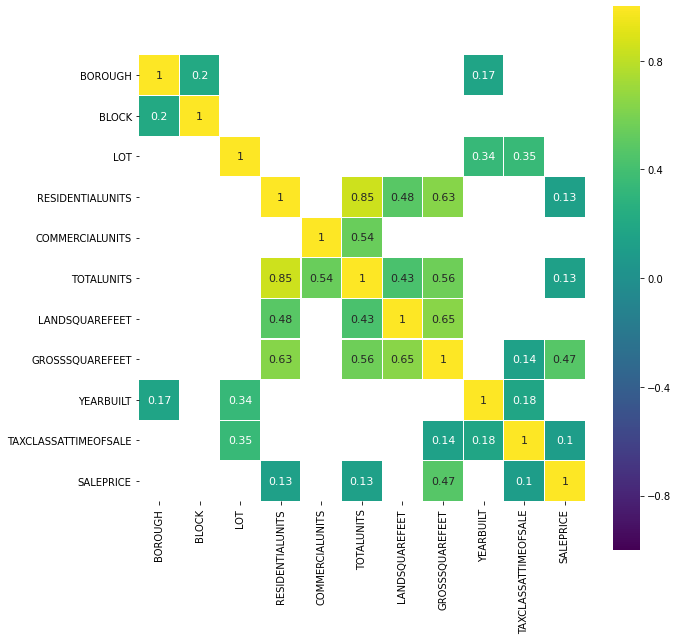

In [47]:
#Corr plot
corr=housing_data.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr[(corr>= 0.1) | (corr <= -0.4)], cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size":11},ax=ax, square=True)

C:\Users\seans\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

C:\Users\seans\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.

C:\Users\seans\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning:


The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.

C:\Users\seans\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning:


The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor r

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F017472508>,
      dtype=object)

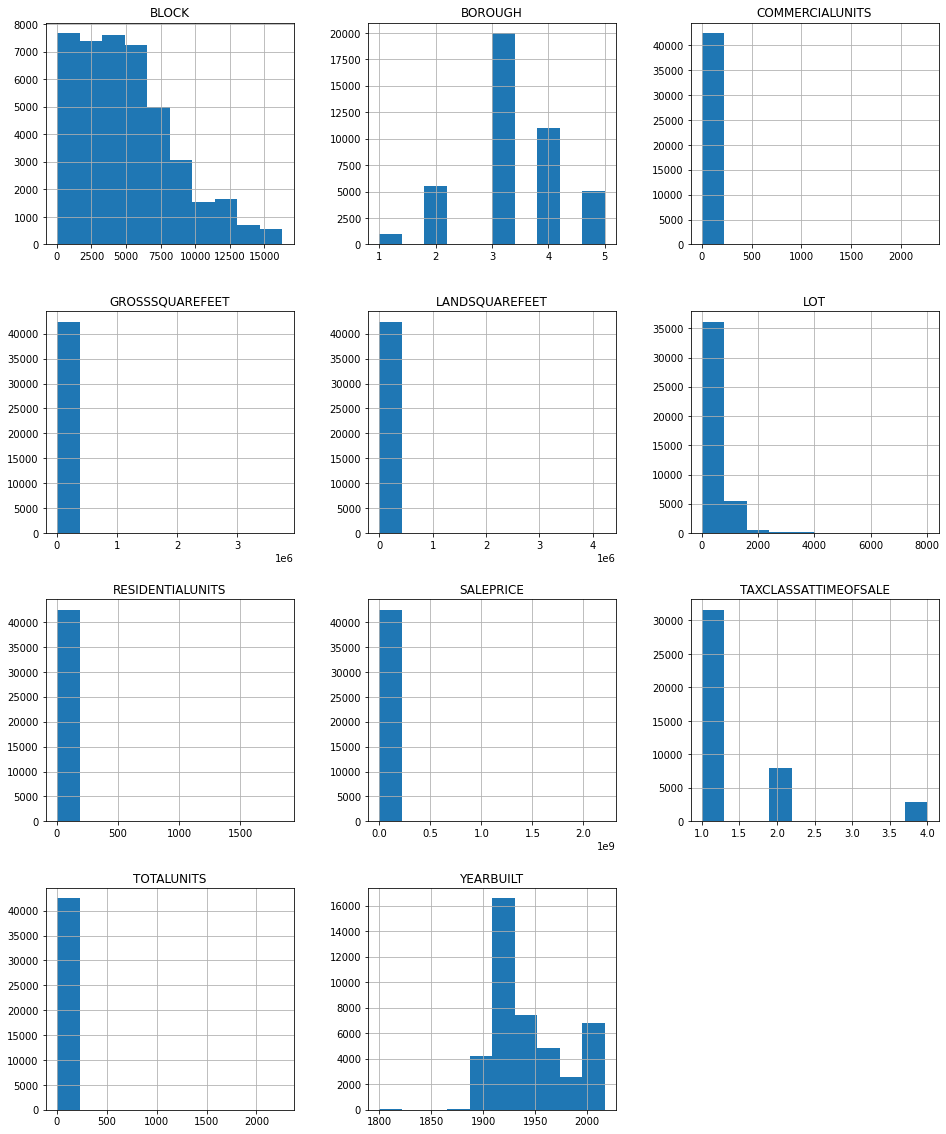

In [48]:
#Extract all of our int64 variables and examine histograms
num_features = housing_data.loc[:, housing_data.dtypes == np.int64]
num_features.hist(figsize=(16, 20))

### THIS TAKES FOREVER TO RUN

Frequency plots for the cateorical Variables

In [49]:
#Counts of the different categorical attributes
#Code derived from a Toward Data Science blog (link:https://towardsdatascience.com/how-to-perform-exploratory-data-analysis-with-seaborn-97e3413e841d)


#fig, ax=plt.subplots(3, 3, figsize=(20, 30))
#for attribute, subplot in zip(housing_data, ax.flatten()):
    #sns.countplot(housing_data[attribute], ax=subplot)
    #for label in subplot.get_xticklabels():
        #label.set_rotation(45)

### ANALYSIS HELPER FUNCTIONS

In [50]:
# Adapted from:
# https://www.featureranking.com/tutorials/machine-learning-tutorials/information-gain-computation/
#https://nbviewer.jupyter.org/github/jakemdrew/MachineLearningExtras/blob/master/LFW%20Dataset%20and%20Class%20Imbalance.ipynb

def gini_index(y):
    probs = pd.value_counts(y,normalize=True)
    return 1 - np.sum(np.square(probs))

def plot_class_dist(y, target_label = None):
    fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
    class_ct = len(np.unique(y))
    vc = pd.value_counts(y)
    print('Total Records', len(y))
    print('Total Classes:', class_ct)
    print('Class Gini Index', gini_index(y))
    print('Smallest Class Id:',vc.idxmin(),'Records:',vc.min())
    print('Largest Class Id:',vc.idxmax(),'Records:',vc.max())
    print('Accuracy when Guessing:', np.round( (1 / len(np.unique(y))) * 100, 2), '%')

    sns.distplot(y, ax=axarr[0], bins=class_ct).set_title('Target Class Distribution:', target_label);
    sns.distplot(y, ax=axarr[1], kde=False, bins=class_ct).set_title('Target Class Counts:', target_label);
    
    
# This function creates dummy encodings from a lsit of features of interest and returns a dataframe     
def create_dummy_encod(ml_df,features_of_interest, drop_first_cat=True, sparsity=True): 
    tmp_cont = []
    ml_data_copy = ml_df.copy()
    for feat in features_of_interest: 
        tmp_df = pd.get_dummies(ml_data_copy[feat],prefix=str(feat),sparse=sparsity,drop_first=drop_first_cat)
        tmp_cont.append(tmp_df)
        feat_df = pd.concat(tmp_cont,axis=1)
        ml_df = pd.concat([ml_data_copy,feat_df], axis=1)
        ml_df = ml_df.drop(columns = features_of_interest, axis = 1)
    return ml_df 



#Adopted from 
#https://nbviewer.jupyter.org/github/jakemdrew/MachineLearningExtras/blob/master/LFW%20Dataset%20and%20Class%20Imbalance.ipynb

# This function provides a way to use stratiefied cv with the test models function below using the default score of accuarcy 

cv = StratifiedKFold(n_splits=10,shuffle=True, random_state=959)

def stratified_cross_validate(model, X, y, cv=cv):
    start = time.time()
    cv_results = cross_validate(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    elapsed_time = (time.time() - start) 
    print ('Fold Scores:')
    print(' ')
    print(cv_results['test_score'])
    print(' ')
    print('Mean Accuracy: ', cv_results['test_score'].mean())
    print('Mean Fit Time: ', cv_results['fit_time'].mean())
    print('Mean Score Time: ', cv_results['score_time'].mean())
    print('CV Time: ', elapsed_time)
    return


#This function provides a quick method to to performe strativied cross validation model comparision 

def test_models(X, y, models, model_names):
    for model, model_name in zip(models,model_names):
        print(model_name)
        print('--------------------------------')
        stratified_cross_validate(model,X,y)
        print(' ')

#This function will plot PCs based on the length of features in the dataframe or change to how many features you wish to input 
def plot_pca(X,var_ratio_pcs = 60):
    # Perform PCA on the data to reduce the number of initial features 
    # and to remove correlations that are common between pixel features 
    pca = PCA(n_components=X.shape[1])
    pca.fit(X)

    # Inspect the explained variances to determine how many components to use  
    plt.subplots(figsize=(8, 8))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    print('Cumulative Explained variance explained with :', var_ratio_pcs , 'components:',sum(pca.explained_variance_ratio_[0:var_ratio_pcs]) )

    



Let's see how many classes we have and their frequencies 

In [51]:
y_num_class = housing_data.BOROUGH.values

We see we have a highly imbalanced data set for Borough values for the outcomes and there is a 20% chance of guessing the class correctly. 
> Couldn't we get 47% just by ugessing 3 ever time?

In [52]:
#Percentage of each borough -- if we just guessed 4 every time, what would our accuracy be?
housing_data['BOROUGH'].value_counts(normalize=True)*100

3    47.047328
4    25.931246
2    12.978573
5    11.801271
1     2.241582
Name: BOROUGH, dtype: float64

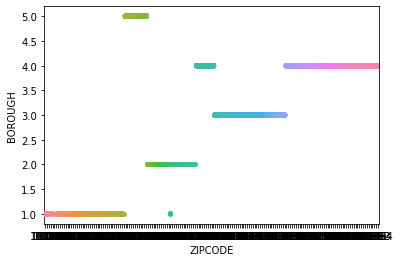

In [53]:
#Is zipcode going to do the entire job for us, or is there some crossover?
sns.stripplot(x=housing_data['ZIPCODE'], y=housing_data['BOROUGH']);


Total Records 42470
Total Classes: 5
Class Gini Index 0.6801381415288976
Smallest Class Id: 1 Records: 952
Largest Class Id: 3 Records: 19981
Accuracy when Guessing: 20.0 %


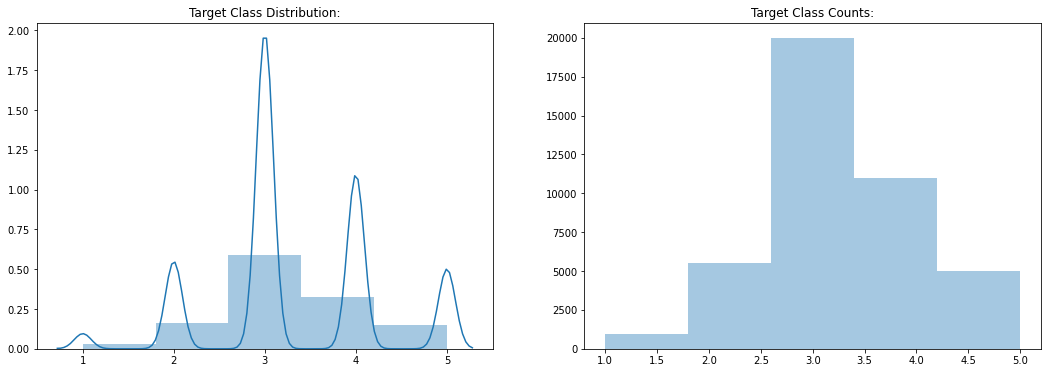

In [54]:
plot_class_dist(y_num_class) 

In [55]:
feat_of_int = [ 'NEIGHBORHOOD', 'BUILDINGCLASSCATEGORY', 'ZIPCODE', 'DECADEBUILT','TAXCLASSATPRESENT', 'BUILDINGCLASSATPRESENT', 'TIMEOFMONTH','BUILDCLASSGENER']
housing_ml_df = housing_data[['NEIGHBORHOOD','BUILDINGCLASSCATEGORY','ZIPCODE', 'DECADEBUILT', 'TAXCLASSATPRESENT', 
                              'BUILDINGCLASSATPRESENT', 'TIMEOFMONTH','BUILDCLASSGENER', 
                              'RESIDENTIALUNITS', 'COMMERCIALUNITS', 'TOTALUNITS',
                              'LANDSQUAREFEET', 'GROSSSQUAREFEET','YEARBUILT',
                              'SALEPRICE','BOROUGH']]
ml_df_enc = create_dummy_encod(ml_df = housing_ml_df,features_of_interest = feat_of_int, drop_first_cat=True, sparsity=True)

In [56]:
ml_df_enc.head(n=5)

RESIDENTIALUNITS  COMMERCIALUNITS  TOTALUNITS  LANDSQUAREFEET  \
0                 5                0           5            1633   
1                10                0          10            2272   
2                 6                0           6            2369   
3                 8                0           8            1750   
4                24                0          24            4489   

   GROSSSQUAREFEET  YEARBUILT  SALEPRICE  BOROUGH  NEIGHBORHOOD_ALPHABET CITY  \
0             6440       1900    6625000        1                           1   
1             6794       1913    3936272        1                           1   
2             4615       1900    8000000        1                           1   
3             4226       1920    3192840        1                           1   
4            18523       1920   16232000        1                           1   

   NEIGHBORHOOD_ANNADALE  ...  BUILDCLASSGENER_OTHER  \
0                      0  ...                      0   
1                      0  ...                      0   
2                      0  ...                      0   
3                      0  ...                      0   
4                      0  ...                      0   

   BUILDCLASSGENER_PUBLIC_REC  BUILDCLASSGENER_PUBLIC_SAFETY  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   BUILDCLASSGENER_REATAIL  BUILDCLASSGENER_RELIGIOUS  BUILDCLASSGENER_SCHOOL  \
0                        0                          0                       0   
1                        0                          0                       0   
2                        0                          0                       0   
3                        0                          0                       0   
4                        0                          0                       0   

   BUILDCLASSGENER_SOCIAL_INSTITUTION  BUILDCLASSGENER_THEATRE  \
0                                   0                        0   
1                                   0                        0   
2                                   0                        0   
3                                   0                        0   
4                                   0                        0   

   BUILDCLASSGENER_WAREHOUSE  BUILDCLASSGENER_ZONED  
0                          0                      0  
1                          0                      0  
2                          0                      0  
3                          0                      0  
4                          0                      0  

[5 rows x 673 columns]

# Modeling and Evaluation 1
>Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.*

Given that we will be creating models for two different tasks, classification and regression, we will need to use two separate metrics to evaluate our models.

###### Classification
For our classification model, our sole concern is accuracy.  We need our model to be able to predict the correct borough with high accuracy in order for our model to be deployable.  Given that this is a multi-class classificaiton issue, our "guessing accuracy" is relatively low, so as long as our accuracy is high and our confusion matrix doesn't show any anomolies, we can be confident in the accuracy metric alone.  

###### Regression
In order to evaluate our regression model, we will want to use a meric that not only provides meaningful insight into the model's performance, but is also interpretable.  With these two parameters in mind, the metric we will use for our regression models is Mean Absolute Error (MAE).  It will allow us to conduct a meaningful evaluation, and being able to use the MAE value in terms of dollars (SALEPRICE being our regression target), making it interpretable. 

# Modeling and Evaluation 2
>Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.*

###### Classification
This model uses 10-fold cross validation because our 70/30 train test split is subject to increased variance if we were to use a single holdout set. 10-fold cross validation helps reduce that variance.
###### Regression

# Modeling and Evaluation 3
>*Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!*

### Classification Section Sean/Billy Edits

In [57]:
#Create scaler object 
ML_std_scalr = StandardScaler()


Let's see what our dataset gives us when we don't scale the data first

In [58]:
y = ml_df_enc['BOROUGH'].values
X = ml_df_enc.drop(columns = ['BOROUGH'], axis = 1).values

In [59]:
# Break our data into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=959, stratify=y)

###    KNN Iteration 1 - No scaling/Stratified CV (10)

Let's see how KNN does without scaling our data first. We will use this as our baseline accuracy for this classification problem. The selection of 3 neighbors is arbitrary.

In [60]:
#https://nbviewer.jupyter.org/github/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3, weights='uniform', metric='euclidean')
stratified_cross_validate(model, X, y, cv=cv)

Fold Scores:
 
[0.6189132  0.61764706 0.60583942 0.60433349 0.60621762 0.60833726
 0.59750353 0.60433349 0.59915214 0.61022138]
 
Mean Accuracy:  0.6072498588404185
Mean Fit Time:  7.111695075035096
Mean Score Time:  2.615864086151123
CV Time:  34.80609059333801


It looks like about 60% without scaling our data and using an arbitrary K value.

Now let's loop through and find our optimal K to improve accuracy.

In [61]:
for K in range(1, 6):
    model = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
    print("K Value:", K)
    stratified_cross_validate(model, X, y, cv=cv)
    print("\n")
    print("----------------------------------")
    print("\n")

K Value: 1
Fold Scores:
 
[0.61514938 0.61011765 0.60348481 0.60080075 0.60080075 0.60197833
 0.58714084 0.59185115 0.59561941 0.60268488]
 
Mean Accuracy:  0.6009627955185085
Mean Fit Time:  6.4846217155456545
Mean Score Time:  2.091312837600708
CV Time:  32.833837032318115


----------------------------------


K Value: 2
Fold Scores:
 
[0.59680075 0.60305882 0.5952437  0.59302873 0.59585492 0.59491286
 0.58737635 0.59279322 0.58737635 0.59821008]
 
Mean Accuracy:  0.5944655797748616
Mean Fit Time:  6.599626231193542
Mean Score Time:  2.366875338554382
CV Time:  34.16279721260071


----------------------------------


K Value: 3
Fold Scores:
 
[0.6189132  0.61764706 0.60583942 0.60433349 0.60621762 0.60833726
 0.59750353 0.60433349 0.59915214 0.61022138]
 
Mean Accuracy:  0.6072498588404185
Mean Fit Time:  7.1794527769088745
Mean Score Time:  2.625195837020874
CV Time:  35.81581449508667


----------------------------------


K Value: 4
Fold Scores:
 
[0.62949894 0.63011765 0.6220861

Based on `Mean Accuracy` 5 is the best K value for our unscaled model.

Now we will scale the data and re-run our loop to examine accuracy and identify the optimal K value.

###  KNN Iteration 2 - scaling/Stratified CV (10)

#### Warning: Takes about 5 mins to run

Scaling the data is necessary in this instance because KNN is a distance based model and will give higher weight to the variables with a larger scale. The below function brings the data into the same scale.

In [62]:
#scale data
X = ML_std_scalr.fit_transform(X)

Now we will find the optimal K value for our model with scaled data.

In [63]:
for K in range(1, 6):
    model = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric='euclidean')
    print("K Value:", K)
    stratified_cross_validate(model, X, y, cv=cv)
    print("\n")
    print("----------------------------------")
    print("\n")

K Value: 1
Fold Scores:
 
[0.98917902 0.98941176 0.98940429 0.99010834 0.9879887  0.99034385
 0.99175695 0.9865756  0.99010834 0.99152143]
 
Mean Accuracy:  0.989639826980035
Mean Fit Time:  39.75164918899536
Mean Score Time:  4.011751270294189
CV Time:  67.52412509918213


----------------------------------


K Value: 2
Fold Scores:
 
[0.98800282 0.98752941 0.98799152 0.98893076 0.98492699 0.98728215
 0.99081488 0.98327838 0.9879887  0.99057937]
 
Mean Accuracy:  0.987732498274027
Mean Fit Time:  38.963379979133606
Mean Score Time:  5.017312407493591
CV Time:  67.35964488983154


----------------------------------


K Value: 3
Fold Scores:
 
[0.98588567 0.98611765 0.98657876 0.98681112 0.9835139  0.98563354
 0.98845973 0.9835139  0.98516251 0.98822421]
 
Mean Accuracy:  0.9859900970862103
Mean Fit Time:  39.11261701583862
Mean Score Time:  6.021177482604981
CV Time:  69.21331453323364


----------------------------------


K Value: 4
Fold Scores:
 
[0.98588567 0.98729412 0.98681422 0.

Based on `Mean Accuracy`, 1 is the best K value for our scaled model with an accuracy of 99%.

Cumulative Explained variance explained with : 500 components: 0.9891836515874082


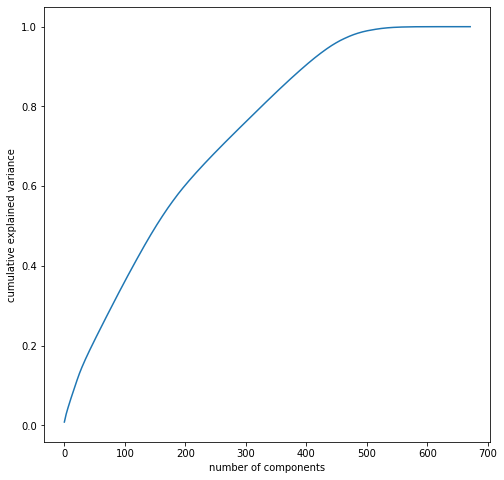

In [64]:
#Plot PCA 
plot_pca(X,var_ratio_pcs = 500)

It looks like it doesn't drastically reduce our dimensionality. It takes 500 components to explain 98.92% of the variance.  Unless we run into any major roadblocks with accuracy, we can just continue with scaled data.

# THIS TAKES A VERY LONG TIME--I STOPPED THE KERNEL AT 15 MINUTES

#PCA pipeline
from sklearn.pipeline import Pipeline

yhat = np.zeros(y.shape) # we will fill this with predictions

# create cross validation iterator
cv = StratifiedKFold(n_splits=10)

# setup pipeline to take PCA, then fit a KNN classifier
clf_pipe = Pipeline(
    [('PCA_Eric',PCA(n_components=500,svd_solver='randomized')),
     ('CLF_Eric',KNeighborsClassifier(n_neighbors=3))]
)

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    clf_pipe.fit(X[train],y[train])
    yhat[test] = clf_pipe.predict(X[test])

total_accuracy = mt.accuracy_score(y, yhat)
print ('KNN, pipeline accuracy', total_accuracy)

## Naive Bayes Iteration 1 - CV (10)

Since our dataset is sparse due to the OneHotEncoding, we will see whether Multinomial or Bernoulli is best.  The GausianNB will likely not be as effective due to the large number of zeros in the dataset.

The below code resets the data set to the original, unscaled values.

In [65]:
y = ml_df_enc['BOROUGH'].values
X = ml_df_enc.drop(columns = ['BOROUGH'], axis = 1).values

Let's establish a baseline accuracy for the unscaled data, using the Multinomial Naive Bayes model. We will test across alpha values of 0.001, 0.5, and 1 to find the best alpha value. Additionally, we will use 10-fold cross validation to reduce the variance in our test set.

In [66]:
from sklearn.naive_bayes import MultinomialNB

#First, let's check multinomial
for a in [0.001, 0.5, 1]:
    model= MultinomialNB(alpha=a)
    print("alpha value:", a)
    stratified_cross_validate(model, X, y, cv=cv)
    print("\n")
    print("------------------------")
    print("\n")

alpha value: 0.001
Fold Scores:
 
[0.48976711 0.48588235 0.4914057  0.47644842 0.49364107 0.4924635
 0.48021667 0.47079604 0.48822421 0.4865756 ]
 
Mean Accuracy:  0.48554206851912374
Mean Fit Time:  2.3331931829452515
Mean Score Time:  0.12776269912719726
CV Time:  24.501542806625366


------------------------


alpha value: 0.5
Fold Scores:
 
[0.48506234 0.48117647 0.48693195 0.47268017 0.49010834 0.48822421
 0.47432878 0.46632124 0.48233632 0.48186528]
 
Mean Accuracy:  0.48090351037386514
Mean Fit Time:  2.233983564376831
Mean Score Time:  0.13984413146972657
CV Time:  24.429939031600952


------------------------


alpha value: 1
Fold Scores:
 
[0.48459186 0.48047059 0.48646103 0.47244465 0.48963731 0.48775318
 0.47385775 0.46608573 0.4821008  0.48092322]
 
Mean Accuracy:  0.48043261180668984
Mean Fit Time:  2.245088267326355
Mean Score Time:  0.13422229290008544
CV Time:  24.612016916275024


------------------------




It appears that an alpha value of 0.001 is best for our Multinomial Naive Bayes model and produces an accuracy rating of 48.6%, far lower than our KNN model with unscaled data. 

Next, we will rerun the 10-fold cross validation with scaled data.  Due to the fact that StandardScalar can produce negative values, which does not work with Niave Bayese, we will use MinMaxScalar to function with the Niave Bayes models.

### Naive Bayes Iteration 2 - Scaled Data/Multinomial

In [67]:
from sklearn.preprocessing import MinMaxScaler

#Multinomial with scaled data

#scale data using MinMaxScaler (Regular scaler provided negative numbers)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#multinomialNB
for a in [0.001, 0.5, 1]:
    model= MultinomialNB(alpha=a)
    print("alpha value:", a)
    stratified_cross_validate(model, X, y, cv=cv)
    print("\n")
    print("------------------------")
    print("\n")

alpha value: 0.001
Fold Scores:
 
[0.99952952 1.         0.99976454 0.99976448 0.99929345 0.99952897
 0.99976448 0.99905794 1.         1.        ]
 
Mean Accuracy:  0.9996703388565237
Mean Fit Time:  1.7039921045303346
Mean Score Time:  0.01718637943267822
CV Time:  3.359713077545166


------------------------


alpha value: 0.5
Fold Scores:
 
[0.99670666 0.99717647 0.99835178 0.9955252  0.99623175 0.99576072
 0.99623175 0.99434762 0.99811587 0.99764484]
 
Mean Accuracy:  0.9966092654039953
Mean Fit Time:  1.7342948198318482
Mean Score Time:  0.018751692771911622
CV Time:  3.448751449584961


------------------------


alpha value: 1
Fold Scores:
 
[0.99553046 0.99552941 0.99693902 0.99434762 0.99481865 0.99505417
 0.99481865 0.99269901 0.99693829 0.99576072]
 
Mean Accuracy:  0.9952436008247778
Mean Fit Time:  1.7661635637283326
Mean Score Time:  0.012499570846557617
CV Time:  3.5472147464752197


------------------------




After iterating through various alpha values, it appears that MultinomialNB performs better with a lower alpha value (less smoothed data).  An alpha value of 0.001 produced a mean 10-fold cross-validated accuracy of 99.97%.

We will now test Bernoulli using a static alpha of 0.001, but testing binarize values of 0.001, 0.5, and 1. Again, we will use 10-fold cross validation.

## Naive Bayes Iteration 3 - Scaled Data/Bernoulli


In [68]:
from sklearn.naive_bayes import BernoulliNB

#BernoulliNB
#We have already seen that we do not want a large alpha value for smoothing
#Let's iterate through the BernoulliNB with some different binarize values to see what produces the best results.
for b in [0.001, 0.5, 1]:
    model= BernoulliNB(alpha=0.001, binarize=b)
    print("binarize value:", b)
    stratified_cross_validate(model, X, y, cv=cv)
    print("\n")
    print("------------------------")
    print("\n")


binarize value: 0.001
Fold Scores:
 
[0.99764761 0.99952941 0.99858724 0.99764484 0.99740933 0.99858691
 0.99670278 0.99717381 0.99905794 0.99858691]
 
Mean Accuracy:  0.99809267680295
Mean Fit Time:  2.2847528219223023
Mean Score Time:  0.0781217098236084
CV Time:  4.553068399429321


------------------------


binarize value: 0.5
Fold Scores:
 
[0.99929428 1.         0.99976454 0.99976448 0.99882242 0.99952897
 0.99976448 0.99905794 1.         1.        ]
 
Mean Accuracy:  0.9995997118238774
Mean Fit Time:  2.219948673248291
Mean Score Time:  0.08201863765716552
CV Time:  4.4744439125061035


------------------------


binarize value: 1
Fold Scores:
 
[0.4702423  0.47011765 0.47044973 0.47056053 0.47056053 0.47056053
 0.47056053 0.47056053 0.47056053 0.47056053]
 
Mean Accuracy:  0.4704733365097242
Mean Fit Time:  2.2291950941085816
Mean Score Time:  0.0741243839263916
CV Time:  4.390718698501587


------------------------




Binarize values of 0.001 and 0.5 both produce very high accuracy values, but the binarize value of 0.001 performs slightly better in terms of time it takes to run, likely because it does not have to binarize more data.

Let's take a look at the confusion matrix to ensure that our high accuracy numbers are not disproportionately affected by a particular class.

With BernoulliNB and a binarize value of 0.001, we get an accuracy of 99.95%. 

### Logistic Regression Iteration 1 - Unscaled Data

Once again, we reset our data to the original, unscaled data set to use for our initial logistic regression model.

In [70]:
#Reset Data after PCA
y = ml_df_enc['BOROUGH'].values
X = ml_df_enc.drop(columns = ['BOROUGH'], axis = 1).values

We will once again use 10-fold cross validation to determine a baseline accuracy score for logistic regression.

In [71]:
#https://nbviewer.jupyter.org/github/jakemdrew/MachineLearningExtras/blob/master/LFW%20Dataset%20and%20Class%20Imbalance.ipynb
model = LogisticRegression(solver='liblinear', random_state=959)
stratified_cross_validate(model, X, y, cv=cv)

Fold Scores:
 
[0.48764996 0.49129412 0.48504827 0.48563354 0.48775318 0.49293453
 0.48845973 0.48704663 0.48634008 0.48610457]
 
Mean Accuracy:  0.48782646079690234
Mean Fit Time:  5.211471891403198
Mean Score Time:  0.13947253227233886
CV Time:  29.609408140182495


We will use 48.7% as our baseline accuracy for logistic regression. Let's take a look at the confusion matrix.

### Logistic Regression Iteration 2 - Scaled data

Once again, we will scale the features, in hopes of improving accuracy.

In [72]:
#reset X and y
# Break our data into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=959, stratify=y)

In [73]:
#Scaling the features will likely make a big improvement to accuaracy 
X = ML_std_scalr.fit_transform(X)

Next, we will run the model using 10-fold cross validation on the scaled data.

In [74]:
model = LogisticRegression(solver='liblinear', random_state=959)
stratified_cross_validate(model, X, y, cv=cv)

Fold Scores:
 
[0.99976476 1.         1.         1.         0.99952897 1.
 1.         1.         1.         1.        ]
 
Mean Accuracy:  0.9999293729673535
Mean Fit Time:  67.31259543895722
Mean Score Time:  0.015628409385681153
CV Time:  103.38029170036316


Scaling the data drastically improves the accuracy of our model. With scaled data the `Mean Accuracy` of our logistic regression model is 88.8%. While it takes a bit longer to fit than the unscaled model, the improvement in accuracy is worth the CV Time tradeoff. Let's run the basic parameters through a SearchGrid and see if that helps the model's performance.

### Logistic Regression Iteration 3 - GridSearch on Scaled Data

##### GridSearch to Identify the best parameters

Due to the number of combinations, we will use 3-fold cross validation so the CV time is not prohibitiely long."

In [78]:
#Create a Logistic Regression object and perform a grid search to find the best parameters
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

logreg = LogisticRegression()
penalty = ['l2']
C = (1, 5, 10)
solver = ['sag', 'saga', 'lbfgs']

parameters = dict(C=C, penalty=penalty, solver=solver)

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
logregGridSearch = GridSearchCV(estimator=logreg
                   , verbose=0 # low verbosity
                   , param_grid=parameters
                   , cv=3 # KFolds = 10 
                   , n_jobs = -1
                               )

#Perform hyperparameter search to find the best combination of parameters for our data
logregGridSearch.fit(X,y)

C:\Users\seans\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': (1, 5, 10), 'penalty': ['l2'],
                         'solver': ['sag', 'saga', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [79]:
#Adopted from https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
#Print out our best parameters to plug into our logistic regression model

print("The optimal parameters according to the gridsearch are: " ,logregGridSearch.best_params_)



The optimal parameters according to the gridsearch are:  {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


Now we'll re-run our logistic regression model after discovering the optimal parameters.

In [81]:
logreg_clf = LogisticRegression(penalty='l2', C=10, solver='lbfgs', random_state=959)
stratified_cross_validate(logreg_clf, X, y, cv=cv)

Fold Scores:
 
[1.         1.         1.         1.         0.99976448 0.99976448
 1.         1.         1.         1.        ]
 
Mean Accuracy:  0.9999528968440885
Mean Fit Time:  27.60204658508301
Mean Score Time:  0.019516777992248536
CV Time:  42.22965717315674


It seems that tuning the parameters based on the GridSearch increased our accuracy even closer to 100%. Similarly, it has decreaed the CV time form over 100 seconds to 42 seconds. We will use the tuned Logistic Regression iteration as our final classifier in the comparison.

### Regression Section 

CappedLinearRegression

In [ ]:
#Create a Linear Regression object and perform a grid search to find the best parameters
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)


In [ ]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

regGridSearch.best_estimator_

In [ ]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
scoresResults_CappedReg =  EvaluateRegressionEstimator(regEstimator, X_regr,y_regr, cv)

mae_avg_CappedLinearRegression = scoresResults_CappedReg['MAE'].mean()
scoresResults_CappedReg

Running 10 CV with SVR will take more than 308s on this machine, I wil use 10 CV SDG using the RBF kernel from Nystroem for grid searching 

Lasso

In [ ]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr,y_regr)

In [ ]:
regGridSearch.best_estimator_

In [ ]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation
regEstimator = Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=0, selection='random',
      tol=0.0001, warm_start=True)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_Lasso = EvaluateRegressionEstimator(regEstimator, X_regr,y_regr, cv)

mae_avg_Lasso = scoresResults_Lasso['MAE'].mean()
scoresResults_Lasso

In [ ]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
#What is the maximum price pridcted?

regEstimator = Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=0, selection='random',
      tol=0.0001, warm_start=True)

regEstimator.fit(X_regr,y_regr)
yhat = regEstimator.predict(X_regr)
print('Target Max: ', y_regr.max())
print("Yhat Max: ", yhat.max())

GradientBooster

In [ ]:
#Fit to data for scaling
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb


ML_std_scalr.fit(X_regr)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_regr_scl = ML_std_scalr.transform(X_regr)

In [ ]:

#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
linreg = GradientBoostingRegressor()

parameters = { 'loss' : ['ls']
              ,'learning_rate' : [1e-3, 1e-1]
              ,'n_estimators': [500] 
              ,'criterion': ['mae']
              ,'min_samples_split':[2,3,4,5]
              ,'min_samples_leaf': [10, 25, 50]
              ,'max_features' : ['auto']
              ,'subsample' : [1e-2]
#              ,'n_jobs':[8] 
              ,'random_state': [0]
             }



              

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl , y_regr)

In [ ]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
#Display the best estimator parameters
regGridSearch.best_estimator_

In [ ]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_GradientBoostingRegressor = EvaluateRegressionEstimator(regEstimator, X_regr_scl , y_regr, cv)


mae_avg_GradientBoostingRegressor = scoresResults_GradientBoostingRegressor['MAE'].mean()
scoresResults_GradientBoostingRegressor

# Modeling and Evaluation 4
>Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.*

### Classification

##### Confusion matrix for KNN:

KNN accuracy 0.9896397457028491


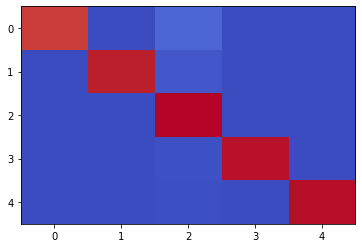

In [82]:
#Confusion Matrix for K=1

# Break our data into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=959, stratify=y)

yhat = np.zeros(y.shape) # we will fill this with predictions

# get a handle to the classifier object, which defines the type
knn_clf = KNeighborsClassifier(n_neighbors=1, weights='uniform', metric='euclidean')

# now iterate through and get predictions, saved to the correct row in yhat
for train, test in cv.split(X,y):
    knn_clf.fit(X[train],y[train])
    yhat[test] = knn_clf.predict(X[test])


#confusion matrix for our KNN iteration 1
cm = mt.confusion_matrix(y, yhat)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('coolwarm'),aspect='auto')
plt.grid(False)

As we can see in the confusion matrix above, the model primarily misclassifies the target bouroughs as bourough 3 (2 on the confusion matrix).  This makes sense as observations for borough 3 were more than 40% of our dataset.  

##### Confustion Matrix for MultinomialNB

MultinomialNB accuracy 0.9896397457028491


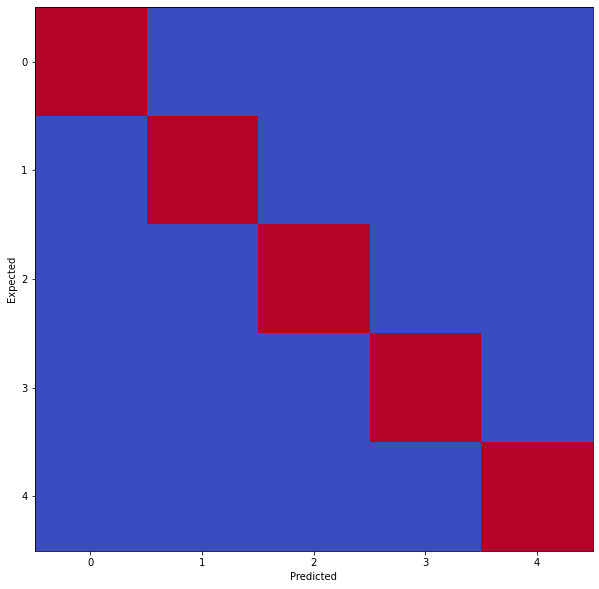

In [83]:
#Reset Data for MinMaxScalar
y = ml_df_enc['BOROUGH'].values
X = ml_df_enc.drop(columns = ['BOROUGH'], axis = 1).values

#Scale Data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Break our data into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=959, stratify=y)

#confusion matrix for our Logistic Regression iteration 2
mnb_clf= MultinomialNB(alpha=0.001)
mnb_clf.fit(X_train, y_train)
y_pred = mnb_clf.predict(X_test)



# Create a confusion matrix to see what classes the logistic regression is getting wrong 


plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('coolwarm'),aspect='auto')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.grid(False)

When we look at the confusion matrix for the MultinomialNB model, we can see that the misclassification issue with borough 3 is no longer present.  This makes sense as the imporovement in accuracy above the KNN model would have been improvements in the correct classificaiton of those boroughs.

##### Confusion Matrix for Logistic Regression 

C:\Users\seans\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



Logistic Regression accuracy 0.9896397457028491


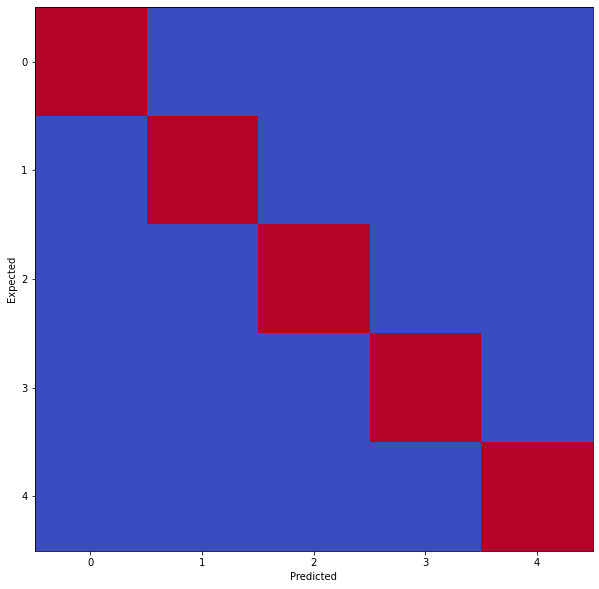

In [84]:
#Reset Data for StandardScalar
y = ml_df_enc['BOROUGH'].values
X = ml_df_enc.drop(columns = ['BOROUGH'], axis = 1).values

#scale data
X = ML_std_scalr.fit_transform(X)

# Break our data into 70% training and 30% test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=959, stratify=y)

#confusion matrix for our Logistic Regression iteration 2
lr_clf = LogisticRegression(penalty='l2', C=10, solver='lbfgs', random_state=959)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

# Create a confusion matrix to see what classes the logistic regression is getting wrong 

plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('coolwarm'),aspect='auto')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.grid(False)

What we can observe with the confusion matrix above is similar to the confusion matrix we saw with the MultinomialNB model.  This color scale can easily detect misclassifications (as well as show our school spirit), and it would follow that the confusion matrix appears pritine as the tuned logistic regression model provided a 10-fold cross-validated score of nearly 100%.  

### Regression

In [ ]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

pca = PCA(n_components=400) 

pipe = Pipeline([('scaler',ML_std_scalr), ('pca', pca)]) 

pipe.fit(X_regr, y_regr)

X_regr_scl_p = pipe.transform(X_regr)


#Create a grid search object using the parameters above

regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl_p,y_regr)

# Modeling and Evaluation 5
>*Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.*

### Statistical Analysis of KNN vs Naive Bayes

In [89]:
# %load -r 1-15 statcompare.py
clf1 = knn_clf #Top performing KNN Model

#Reset Data for MinMaxScalar
y = ml_df_enc['BOROUGH'].values
X = ml_df_enc.drop(columns = ['BOROUGH'], axis = 1).values

#Scale Data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
                         
clf2 = mnb_clf #Top performing Naive Bayes


from sklearn.model_selection import cross_val_score
# is clf1 better or worse than clf2?
cv=StratifiedKFold(n_splits=10)
acc1 = cross_val_score(clf1, X, y=y, cv=cv)
acc2 = cross_val_score(clf2, X, y=y, cv=cv)

### Correction for multiple tests

Since we are doing two concurent hypothesis tests, we will do a bonferroni correction by dividing alpha by 2 (0.5/2=0.025).  Our new critical t-value becomes 2.28
>T-value derived from: https://www4.stat.ncsu.edu/~jaosborn/st512r/labs/t-table.pdf

In [90]:
# %load -r 19-28 statcompare.py
t = 2.28 / np.sqrt(10)

e = (1-acc1)-(1-acc2)
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (np.mean(acc1), np.mean(acc2))

Range of: 0.10389112541804806 0.17949536681998124
0.8096056332417565 0.9512988793607713


h0: The mean accuracy of KNN and the mean acuracy of Multinomial Naive Bayes is the same
ha: The mean accuracies of the two models are different


###### Conclusion 1:
Given the confidence interval of the differnece does not include zero, we have sufficient evidence to reject h0.  We are 95% confident that the mean accuracy of MultinomialNB is between 10.39% and 17.95% higher than KNN.

Given that there is no statistical difference between the accuracies of Multinomial Naive Bayes and Logistic Regression, we can look at secondary metrics, such as runtime.  In our model classification iterations, Multinomial Naive Bayes had a much lower cross validation time. Niave Bayes took only 3-5 seconds verus over 100 seconds with Logistic Regression.  Although the speed of our model isn't necessarily instrumental for deployment, it makes sense to utilize a faster model with the same accuracy--Niave Bayes.  

### Statistical Comparison ov Naive Bayes vs Logistic Regression

In [97]:
#Reset Data for MinMaxScalar
y = ml_df_enc['BOROUGH'].values
X = ml_df_enc.drop(columns = ['BOROUGH'], axis = 1).values

#Scale Data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

clf1 = mnb_clf #Top performing Naive Bayes

In [99]:
# %load -r 1-15 statcompare.py


#clf1 = mnb_clf #Top performing Naive Bayes

#Reset Data for StandardScalar to use Logistic Regression
y = ml_df_enc['BOROUGH'].values
X = ml_df_enc.drop(columns = ['BOROUGH'], axis = 1).values

#scale data
X = ML_std_scalr.fit_transform(X)

clf1 = lr_clf #Top performing logistic Regression model

#Reset Data for MinMaxScalar
y = ml_df_enc['BOROUGH'].values
X = ml_df_enc.drop(columns = ['BOROUGH'], axis = 1).values

#Scale Data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
                         
clf2 = mnb_clf #Top performing Naive Bayes

from sklearn.model_selection import cross_val_score
# is clf1 better or worse than clf2?
cv=StratifiedKFold(n_splits=10)
acc1 = cross_val_score(clf1, X, y=y, cv=cv)
acc2 = cross_val_score(clf2, X, y=y, cv=cv)

C:\Users\seans\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\seans\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

C:\Users\seans\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\seans\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\seans\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.

C:\Users\seans\Anaconda3\lib\site-packages\sk

In [100]:
# %load -r 19-28 statcompare.py
t = 2.28 / np.sqrt(10)

e = (1-acc1)-(1-acc2)
# std1 = np.std(acc1)
# std2 = np.std(acc2)
stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (np.mean(acc1), np.mean(acc2))

Range of: -0.03489714754637339 0.013728031743089944
0.961883437262413 0.9512988793607713


h0: The mean accuracy of Multinomial Naive Bayes and the mean acuracy of Logistic Regression is the same

ha: The mean accuracies of the two models are different

Given the confidence interval of the differnece includes zero, we do not have sufficient evidence to reject h0.  Therefore, we can not confidently conclude that Mulinomial Naive Bayes and Logistic Regression have different mean accuracies.

Given that these two classifiers are not statistically significant, we can default to the model tha thas the shortest runtime.  While our main concern is accuracy, we can choose the model which is more efficient, which is Multinomial Naive Bayes using scaled data.

### Regression

In [ ]:
#Adapted from 
#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb

#Gradient Bosting
regr1 = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=25, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)



regest1 = Pipeline(
    [('scaler',ML_std_scalr),
     ('regr',regr1)]
)

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
reg_err1 = cross_val_score(regest1, X_regr, y_regr, cv=cv, scoring = 'neg_mean_absolute_error')


In [ ]:
#Lasso
regr2 = Lasso(alpha=10, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=0, selection='random',
      tol=0.0001, warm_start=True)

regest2 = Pipeline(
    [('scaler',ML_std_scalr),
     ('regr',regr2)]
)

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

reg_err2 = cross_val_score(regest2, X_regr, y_regr, cv=cv, scoring = 'neg_mean_absolute_error')

In [ ]:
#Adapted from 
#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb

#CappedLinear Regression
regr3 = CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)

regest3 = Pipeline(
    [('scaler',ML_std_scalr),
     ('regr',regr3)]
)

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

reg_err3 = cross_val_score(regest3, X_regr, y_regr, cv=cv, scoring = 'neg_mean_absolute_error')

BONFERRONI correction for multiple comparison to minimize Type I error.

Comparing GradientBoostingRegressor and Lasso, the 95% confidence interval [26535.66, 43496.91] shows that the interval doesn't includes zero, which implies that the two models are statistically different and we reject null hypothesis. Further, Mean absolute error(MAE) for Lasso with PCA model is 359,309.74 which is less than Mean absolute error(MAE) for GradientBoostingRegressor with PCA model, which is 394,325.93. Hence Lasso with PCA is better model in this comparison.

In [ ]:
# wanting to check 3 models, so bonferroni correction for alpha = 0.05 / 3 = 0.0125 therefore t = 3.169 
# we reject h0 the models are statistically different, as zero is not in the interval, The LASSO model is the better 
#regressor model. 


t = 3.169 / np.sqrt(10)

e = abs(reg_err1) - abs(reg_err2) 

stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (abs(np.mean(reg_err1)), abs(np.mean(reg_err2)))

Comparing Lasso and CappedLinearRegression, the 95% confidence interval [34561.30, 42018.82] shows that the interval doesn't includes zero, which implies that the two models are statistically different and we reject null hypothesis. Further, Mean absolute error(MAE) for Lasso with PCA model is 359,309.74 which is greater than Mean absolute error(MAE) for Lasso with more predictors model, which is 321019.68. Hence Lasso with more predictors model is better model in this comparison.

In [ ]:
# fail to reject h0, the models are not statistically different, 
#there is not sufficient evidence to suggest the error from the capped linear regression and the lasso regression 
# is different. 
t = 3.169 / np.sqrt(10)

e =  abs(reg_err2) - abs(reg_err3)

stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (abs(np.mean(reg_err2)), abs(np.mean(reg_err3)))

Comparing Lasso with PCA and CappedLinearRegression, the 95% confidence interval [25226.12, 40381.07] shows that the interval doesn't includes zero, which implies that the two models are statistically different and we reject null hypothesis. Further, Mean absolute error(MAE) for Lasso with PCA model is 359,309.74 which is greater than Mean absolute error(MAE) for CappedLinearRegression model with more predictors, which is 326,506.15. Hence CappedLinearRegression model with more predictors is better model in this comparison.

In [ ]:
#  reject h0 the models are statistically different, as zero is not in the interval, The LASSO model with more features 
#predicts lower MSE. 
t = 3.169 / np.sqrt(10)

e =  abs(reg_err3) - abs(reg_err1)

stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (abs(np.mean(reg_err3)), abs(np.mean(reg_err2)))

# Modeling and Evaluation 6
>*Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.*

### Classification

For the classification task, we will review the most important features in the Logistic Regression model. 

In [113]:
#Reset Data for StandardScalar to use Logistic Regression
y = ml_df_enc['BOROUGH'].values
X = ml_df_enc.drop(columns = ['BOROUGH'], axis = 1).values

#scale data
X = ML_std_scalr.fit_transform(X)

clf = lr_clf #Top performing logistic Regression model

In [119]:
clf = LogisticRegression(penalty='l2', C=10, solver='lbfgs', random_state=959)
clf.fit(X, y)

C:\Users\seans\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=959, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

[[ 0.00897611  0.00576096  0.01043532 ...  0.01044616  0.02079949
  -0.00624778]
 [ 0.01068911 -0.00390511  0.00675115 ... -0.00397636  0.00840334
   0.00089658]
 [-0.01459135 -0.00994051 -0.01654273 ... -0.00688457  0.00459962
   0.00991827]
 [ 0.01365976  0.00314234  0.01228288 ... -0.00176712  0.0040098
  -0.01685161]
 [-0.0211063  -0.00409779 -0.02065422 ... -0.00384878 -0.00790785
  -0.01065964]]


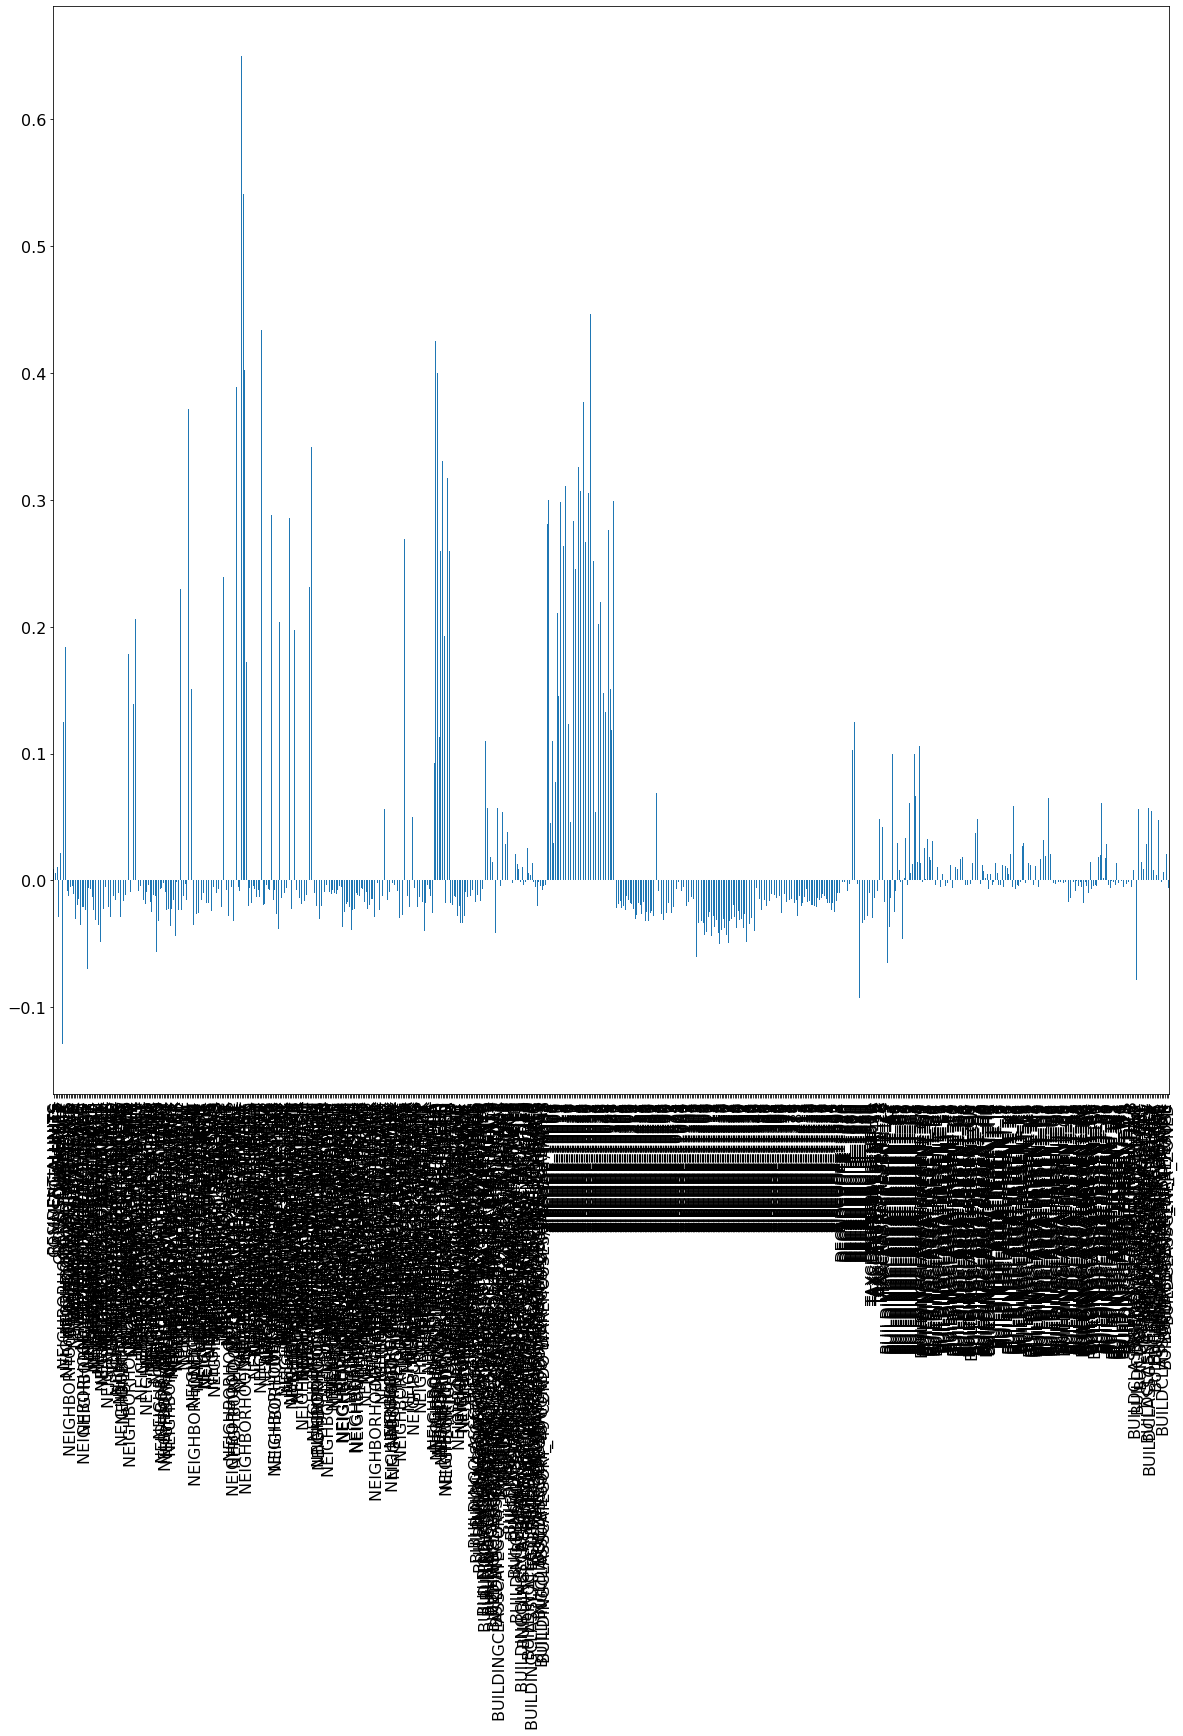

In [125]:
print(clf.coef_)
weights = pd.Series(clf.coef_[0],index=ml_df_enc.drop(columns = ['BOROUGH'], axis = 1).columns)
weights.plot(kind='bar',figsize=(20,20), fontsize=16)

### Regression

## Deployment
*How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?*

This model will be very useful for buying or selling real estate in NY. It provides price prediction and trends in each Borough.

The measurement of the model value is number of users using the model on daily basis. Usage logs will be captured and analyzed constantly to assess model value and appropriate actions are taken to retain the customers.

After training and testing the final model we will make it available for the interested parties or customers by deploying it to production environment. One way to do this is to save the trained Scikit-Learn model using joblib, including the full preprocessing and prediction pipeline into production environment. 

Option1: This strategy is by wrapping the model with a dedicated REST API end point hosted on any Web server which servers HTTP/HTTPS protocols. This pattern will insulate the interface and easier to upgrade the model with new version.

Option2: As various cloud platforms are offering AI/ML hosting platforms. Like Google Cloud Platform (GCP) AI Platform. We will save best model using joblib and upload it to Google Cloud Storage (GCS), then on the Google Clod AI Platform create a new model version, pointing to the GCS file. This will provide load balanced and scaled REST web service. 

Both options take JSON requests as input data and returns JSON responses containing the predictions.
The RESTful API can be consumed by any third-party applications which can consume REST API’s. In addition, we will deploy web application which provides UI to interact with the API’s mentioned above. where users can consume as SaaS.
Any software which goes to production need to be monitored to check model’s live performance and availability. Logs need to be captured for monitoring. Note: It is not always possible to determine the model’s performance without human analysis. Human intervention is also required to maintain the health of the deployed model.

We will refresh the data and train the model every one week, which keep up with seasonal price variation trends by Borough.


## Exceptional Work
*You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?*

### Preliminary Test to Establish Baseline Accuracies 

In [55]:

mods = [
    #XGBClassifier(),
    GaussianNB(), 
    MultinomialNB(),
    SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3,max_iter=5, 
                  tol=None, n_jobs=-1, random_state=42),
    RandomForestClassifier(n_estimators=200, max_depth=3, 
                           n_jobs=-1, random_state=42),
    LinearSVC(random_state=42),
    LogisticRegression(n_jobs=-1, random_state=42)
]

mod_names = ['GaussianNB','MultinomialNB','SGDClassifier',
               'RandomForestClassifier','LinearSVC','LogisticRegression']

test_models(X,y, models = mods, model_names = mod_names)

GaussianNB
--------------------------------
Fold Scores:
 
[0.47377088 0.47341176 0.47115611 0.47362223 0.47268017 0.47597739
 0.47574187 0.47103156 0.47079604 0.47197362]
 
Mean Accuracy:  0.47301616444756894
Mean Fit Time:  2.753628659248352
Mean Score Time:  0.3735030651092529
CV Time:  23.071144342422485
 
MultinomialNB
--------------------------------
Fold Scores:
 
[0.48459186 0.48047059 0.48646103 0.47244465 0.48963731 0.48775318
 0.47385775 0.46608573 0.4821008  0.48092322]
 
Mean Accuracy:  0.48043261180668984
Mean Fit Time:  1.9435141324996947
Mean Score Time:  0.09895274639129639
CV Time:  19.984155416488647
 
SGDClassifier
--------------------------------
Fold Scores:
 
[0.11903082 0.03647059 0.02990346 0.4642016  0.02849741 0.0313236
 0.02873293 0.14154498 0.47126707 0.05511069]
 
Mean Accuracy:  0.14060831512257183
Mean Fit Time:  2.6182922601699827
Mean Score Time:  0.12245190143585205
CV Time:  22.471304178237915
 
RandomForestClassifier
--------------------------------

# Logistic Regression Section

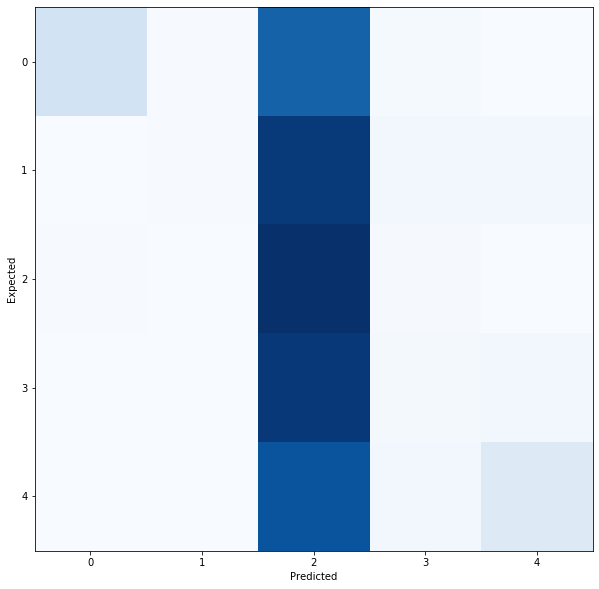

In [55]:
#adapted from 
#https://nbviewer.jupyter.org/github/jakemdrew/MachineLearningExtras/blob/master/LFW%20Dataset%20and%20Class%20Imbalance.ipynb

# Break our data into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=959, stratify=y)

# Use logstic regression to build a model and predict on the test set
lr_clf = LogisticRegression(solver='liblinear', random_state=959)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

# Create a confusion matrix to see what classes the logistic regression is getting wrong 



plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('Blues'),aspect='auto')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.grid(False)

Cumulative Explained variance explained with : 400 components: 0.9028840731247423


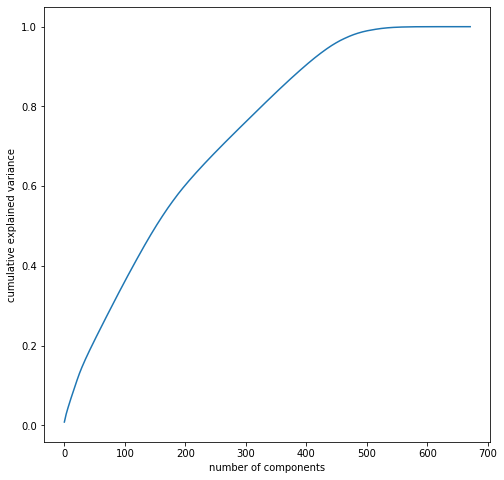

In [56]:
#Scaling the features makes a big improvement to accuaracy 
X = ML_std_scalr.fit_transform(X)

plot_pca(X,var_ratio_pcs = 400)


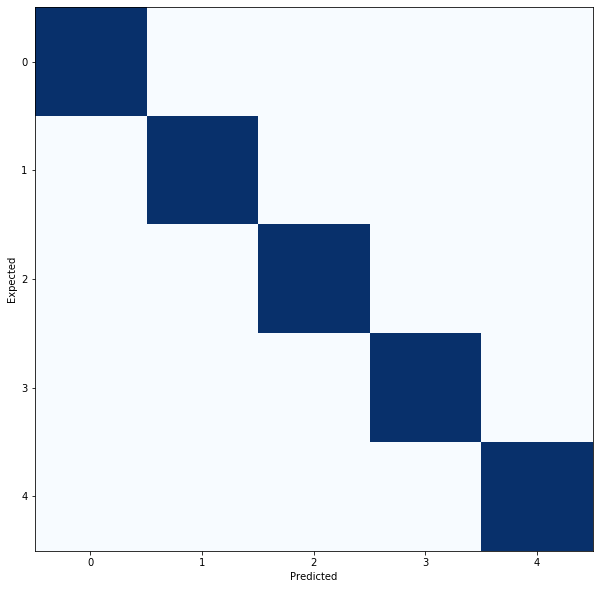

In [57]:
#adapted from 
#https://nbviewer.jupyter.org/github/jakemdrew/MachineLearningExtras/blob/master/LFW%20Dataset%20and%20Class%20Imbalance.ipynb

# Break our data into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=959, stratify=y)

# Use logstic regression to build a model and predict on the test set
lr_clf = LogisticRegression(solver='liblinear', random_state=959)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)

# Create a confusion matrix to see what classes the logistic regression is getting wrong 



plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('Blues'),aspect='auto')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.grid(False)

SMOTE SAMPLING

Total Records 99905
Total Classes: 5
Class Gini Index 0.7999999999999999
Smallest Class Id: 5 Records: 19981
Largest Class Id: 5 Records: 19981
Accuracy when Guessing: 20.0 %


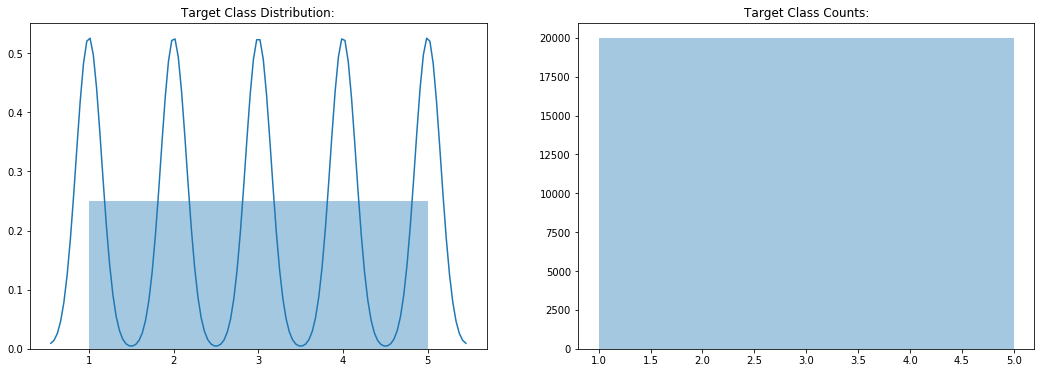

In [58]:
#https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html#smote-variants

smte = SMOTE(sampling_strategy='not majority')
X_smote, y_smote = smte.fit_sample(X, y)

plot_class_dist(y_smote)

Total Records 4760
Total Classes: 5
Class Gini Index 0.7999999999999999
Smallest Class Id: 3 Records: 952
Largest Class Id: 3 Records: 952
Accuracy when Guessing: 20.0 %


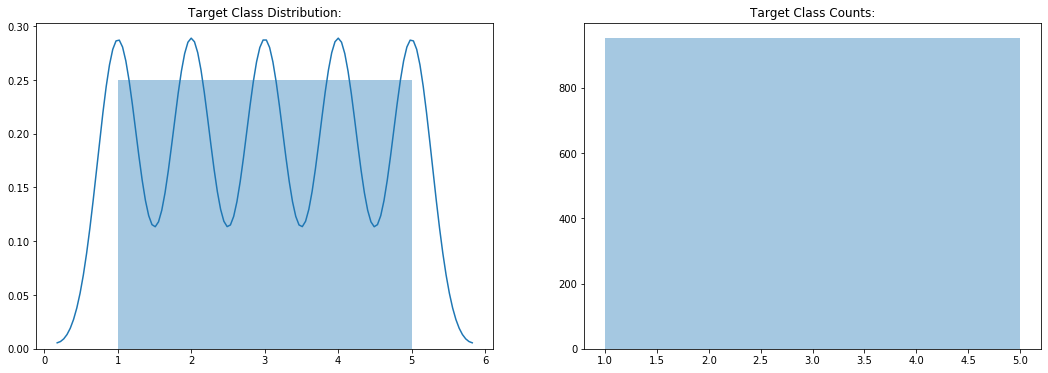

In [59]:
us = RandomUnderSampler()
X_us, y_us = us.fit_sample(X, y)

# Plot the new class distributions for y using the same funnction as above. 
plot_class_dist(y_us)

In [60]:

lr_clf = LogisticRegression(n_jobs=-1, random_state=959)

print('Original Dataset Scaled')
print('----------------------------------------------------------------')
stratified_cross_validate(lr_clf, X, y)
print('\nOversample all Classes to Majority Dataset')
print('----------------------------------------------------------------')
stratified_cross_validate(lr_clf, X_smote, y_smote)
print('\nMinority Undersampled Dataset')
print('----------------------------------------------------------------')
stratified_cross_validate(lr_clf, X_us, y_us)


Original Dataset Scaled
----------------------------------------------------------------
Fold Scores:
 
[1.         1.         1.         1.         1.         1.
 1.         0.99952908 1.         1.        ]
 
Mean Accuracy:  0.9999529079350129
Mean Fit Time:  11.292144179344177
Mean Score Time:  0.011726069450378417
CV Time:  18.32505488395691

Oversample all Classes to Majority Dataset
----------------------------------------------------------------
Fold Scores:
 
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 
Mean Accuracy:  1.0
Mean Fit Time:  27.172484350204467
Mean Score Time:  0.024583864212036132
CV Time:  43.72262215614319

Minority Undersampled Dataset
----------------------------------------------------------------
Fold Scores:
 
[1.         1.         1.         0.99789916 1.         1.
 1.         0.99789916 1.         1.        ]
 
Mean Accuracy:  0.9995798319327731
Mean Fit Time:  1.299431610107422
Mean Score Time:  0.0019050836563110352
CV Time:  2.0981621742248535


## Regression Analysis Helper Functions

In [61]:
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

In [62]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)
mse_scorer = make_scorer(score_func = mean_squared_error, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer, 
                'MSE' : mse_scorer
               } 

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1
    scores['test_MSE'] = scores['test_MSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')
    
    #print mean MAE for all folds 
    MSEavg = scores['test_MSE'].mean()
    print_str = "The average MSE for all cv folds is: \t\t\t {MSEavg:.5}"
    print(print_str.format(MSEavg=MSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    scoresResults['MSE'] = scores['test_MSE']
    return scoresResults

class CappedLinearRegression(LinearRegression):

    def predict(self, X):
        return np.clip(super(CappedLinearRegression, self).predict(X), 1, 2.21e9) 


In [63]:
y_regr = ml_df_enc['SALEPRICE'].values
X_regr = ml_df_enc.drop(columns = ['SALEPRICE'], axis = 1).values

In [64]:
#Create a Linear Regression object and perform a grid search to find the best parameters
linreg = CappedLinearRegression()
parameters = {'normalize':(True,False), 'fit_intercept':(True,False)}

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr,y_regr)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  3.9min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=CappedLinearRegression(copy_X=True, fit_intercept=True,
                                              n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': (True, False),
                         'normalize': (True, False)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [65]:
regGridSearch.best_estimator_

CappedLinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                       normalize=False)

In [66]:
#Create CappedLinearRegression predictions between 0 and 100% using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_regr,y_regr, cv)

The average MAE for all cv folds is: 			 9.1977e+05
The average MAE percentage (MAPE) for all cv folds is: 	 9.2812e+05
The average RMSE for all cv folds is: 			 8.0334e+06
*********************************************************
The average MSE for all cv folds is: 			 7.0846e+13
*********************************************************
Cross Validation Fold Mean Error Scores


MAE          MAPE          RMSE           MSE
0  9.480768e+05  6.913701e+05  8.841970e+06  7.818044e+13
1  8.412510e+05  8.204873e+05  4.308210e+06  1.856067e+13
2  8.835995e+05  5.389290e+05  8.255403e+06  6.815168e+13
3  1.063313e+06  6.510307e+05  1.011826e+07  1.023793e+14
4  9.502896e+05  1.172145e+06  7.598845e+06  5.774244e+13
5  8.621126e+05  1.851525e+06  5.243461e+06  2.749389e+13
6  8.841303e+05  1.316470e+06  7.770839e+06  6.038594e+13
7  1.055049e+06  7.475549e+05  1.363306e+07  1.858603e+14
8  8.766159e+05  7.779677e+05  8.632188e+06  7.451467e+13
9  8.332796e+05  7.136881e+05  5.932133e+06  3.519021e+13

Running 10 CV with SVR will take more than 308s on this machine, I wil use 10 CV SDG using the RBF kernel from Nystroem for grid searching 

In [67]:
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

In [68]:

#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor
#https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html#sklearn.kernel_approximation.Nystroem

reg = SGDRegressor()

feature_map_nystroem = Nystroem(gamma=.2,
                                random_state=1,
                                n_components=400)

X_regr_transformed = feature_map_nystroem.fit_transform(X_regr)

#Set up SVR parameters to test (WARNING: Creates 80 models!!!) 
loss = ['squared_loss', 'epsilon_insensitive']
alphas = [0.0001, 0.1]
penalty = ['l2']
parameters = {'loss': loss, 'alpha' : alphas, 'penalty': penalty }

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_transformed,y_regr)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed: 10.2min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=None,
                                    shuffle=True, tol=0.001,
                                    validation_fraction=0.1, verbose=0,
                                    warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.0001, 0.1],
                         'loss': ['squared_loss', 'epsilon_insensitive'],
                         'penalt

In [69]:
regGridSearch.best_estimator_

SGDRegressor(alpha=0.1, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [70]:
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateRegressionEstimator(regEstimator, X_regr_transformed ,y_regr, cv)

The average MAE for all cv folds is: 			 1.3178e+06
The average MAE percentage (MAPE) for all cv folds is: 	 5.2564e+05
The average RMSE for all cv folds is: 			 8.5622e+06
*********************************************************
The average MSE for all cv folds is: 			 8.0214e+13
*********************************************************
Cross Validation Fold Mean Error Scores


MAE           MAPE          RMSE           MSE
0  1.441719e+06  561609.795911  1.154933e+07  1.333869e+14
1  1.235199e+06  619053.938222  4.028730e+06  1.623067e+13
2  1.453936e+06  662219.557827  8.990279e+06  8.082512e+13
3  1.336294e+06  487713.872504  1.270960e+07  1.615339e+14
4  1.291455e+06  442602.811426  8.645368e+06  7.474239e+13
5  1.082216e+06  454500.802955  6.340188e+06  4.019799e+13
6  1.206384e+06  549658.487828  7.472541e+06  5.583887e+13
7  1.599757e+06  563387.993018  9.190633e+06  8.446774e+13
8  1.337920e+06  456049.080361  1.113616e+07  1.240141e+14
9  1.193251e+06  459635.782488  5.559012e+06  3.090261e+13

In [71]:
reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr,y_regr)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  7.2min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  7.7min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=True, positive=False,
                             precompute=True, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [72]:
regGridSearch.best_estimator_

Lasso(alpha=20, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=0, selection='random',
      tol=0.0001, warm_start=True)

In [73]:
#Create a regression estimator with best parameters for cross validation
regEstimator = Lasso(alpha=20, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=0, selection='random',
      tol=0.0001, warm_start=True)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_regr,y_regr, cv)

The average MAE for all cv folds is: 			 9.662e+05
The average MAE percentage (MAPE) for all cv folds is: 	 1.0492e+06
The average RMSE for all cv folds is: 			 8.381e+06
*********************************************************
The average MSE for all cv folds is: 			 7.7771e+13
*********************************************************
Cross Validation Fold Mean Error Scores


MAE          MAPE          RMSE           MSE
0  9.711862e+05  2.221417e+06  9.029547e+06  8.153272e+13
1  8.708155e+05  7.192085e+05  4.456538e+06  1.986073e+13
2  9.388370e+05  5.384254e+05  8.467478e+06  7.169818e+13
3  1.152248e+06  5.078905e+05  1.186240e+07  1.407166e+14
4  9.858473e+05  1.181406e+06  7.409552e+06  5.490146e+13
5  9.092460e+05  1.869517e+06  5.619097e+06  3.157426e+13
6  9.219394e+05  1.188917e+06  7.945632e+06  6.313307e+13
7  1.111462e+06  7.450777e+05  1.417877e+07  2.010374e+14
8  8.884882e+05  7.951004e+05  8.670025e+06  7.516933e+13
9  9.119357e+05  7.251697e+05  6.171174e+06  3.808339e+13

In [74]:
#What is the maximum price pridcted?
regEstimator = Lasso(alpha=20, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=0, selection='random',
      tol=0.0001, warm_start=True)

regEstimator.fit(X_regr,y_regr)
yhat = regEstimator.predict(X_regr)
print('Target Max: ', y_regr.max())
print("Yhat Max: ", yhat.max())

Target Max:  2210000000
Yhat Max:  2209150691.629846


In [75]:
reg = Ridge(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=1000, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr,y_regr)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 39.5min
[Parallel(n_jobs=8)]: Done 360 out of 360 | elapsed: 46.6min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, random_state=0,
                             solver='auto', tol=0.0001),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg',
                                    'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [76]:
regGridSearch.best_estimator_

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000, normalize=True,
      random_state=0, solver='lsqr', tol=0.0001)

In [77]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_regr,y_regr, cv)

The average MAE for all cv folds is: 			 8.5513e+05
The average MAE percentage (MAPE) for all cv folds is: 	 8.1532e+05
The average RMSE for all cv folds is: 			 7.3725e+06
*********************************************************
The average MSE for all cv folds is: 			 5.9843e+13
*********************************************************
Cross Validation Fold Mean Error Scores


MAE          MAPE          RMSE           MSE
0  9.094536e+05  9.188044e+05  8.957150e+06  8.023054e+13
1  7.181473e+05  7.294409e+05  3.365069e+06  1.132369e+13
2  8.419673e+05  5.546687e+05  7.384044e+06  5.452410e+13
3  9.902448e+05  4.889745e+05  1.049624e+07  1.101710e+14
4  8.993044e+05  9.884647e+05  6.949894e+06  4.830103e+13
5  7.859515e+05  1.302929e+06  5.314809e+06  2.824720e+13
6  7.861306e+05  1.061545e+06  7.251895e+06  5.258999e+13
7  1.034451e+06  6.572457e+05  1.133066e+07  1.283839e+14
8  8.137339e+05  7.436308e+05  7.807298e+06  6.095390e+13
9  7.719474e+05  7.075143e+05  4.868231e+06  2.369967e+13

In [78]:
#Fit to data for scaling

ML_std_scalr.fit(X_regr)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_regr_scl = ML_std_scalr.transform(X_regr)

In [79]:
#linreg = ExtraTreesRegressor()
#parameters = { 'min_samples_split':[2,3,4,5]
#              ,'n_estimators' : [500]
#              ,'min_samples_leaf': [10, 25, 50]
#              ,'criterion': ['mae']
#              ,'n_jobs':[8] 
#              ,'random_state': [0]
#             }

linreg = GradientBoostingRegressor()

parameters = { 'loss' : ['ls']
              ,'learning_rate' : [1e-3, 1e-1]
              ,'n_estimators': [500] 
              ,'criterion': ['mae']
              ,'min_samples_split':[2,3,4,5]
              ,'min_samples_leaf': [10, 25, 50]
              ,'max_features' : ['auto']
              ,'subsample' : [1e-2]
#              ,'n_jobs':[8] 
              ,'random_state': [0]
             }



              

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl , y_regr)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  9.0min
[Parallel(n_jobs=8)]: Done 240 out of 240 | elapsed: 10.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min...
             param_grid={'criterion': ['mae'], 'learning_rate': [0.001, 0.1],
                         'loss': ['ls'], 'max_features': ['auto'],
                 

In [80]:
#Display the best estimator parameters
regGridSearch.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [81]:
#Create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
EvaluateRegressionEstimator(regEstimator, X_regr_scl , y_regr, cv)

The average MAE for all cv folds is: 			 7.6176e+05
The average MAE percentage (MAPE) for all cv folds is: 	 6.0225e+05
The average RMSE for all cv folds is: 			 8.1063e+06
*********************************************************
The average MSE for all cv folds is: 			 7.2929e+13
*********************************************************
Cross Validation Fold Mean Error Scores


MAE           MAPE          RMSE           MSE
0  876101.012307  587450.430237  1.115600e+07  1.244563e+14
1  607896.233038  712915.422077  3.471674e+06  1.205252e+13
2  774620.098082  472943.285715  8.617823e+06  7.426688e+13
3  833635.300805  430535.445891  1.235208e+07  1.525738e+14
4  835553.756352  736210.922857  8.152417e+06  6.646191e+13
5  701482.460046  641851.267265  5.812898e+06  3.378979e+13
6  658708.929454  641660.981403  7.112391e+06  5.058611e+13
7  796120.762815  399896.647742  8.737419e+06  7.634249e+13
8  833540.339632  728943.961936  1.068015e+07  1.140656e+14
9  699921.418608  670077.378488  4.969712e+06  2.469804e+13

In [82]:
#Create a regression estimator with best parameters for cross validation
regEstimator = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#Fit the model using all of the scaled training data
regEstimator.fit(X_regr_scl , y_regr) 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [83]:
ml_df_feats = ml_df_enc.drop(columns = ['SALEPRICE'], axis = 1)

In [84]:
ml_df_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42470 entries, 0 to 43048
Columns: 672 entries, RESIDENTIALUNITS to BUILDCLASSGENER_ZONED
dtypes: Sparse[uint8, 0](665), int64(7)
memory usage: 3.9 MB


In [85]:
weights = regEstimator.feature_importances_.ravel()
feature_names = ml_df_feats.columns.values
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

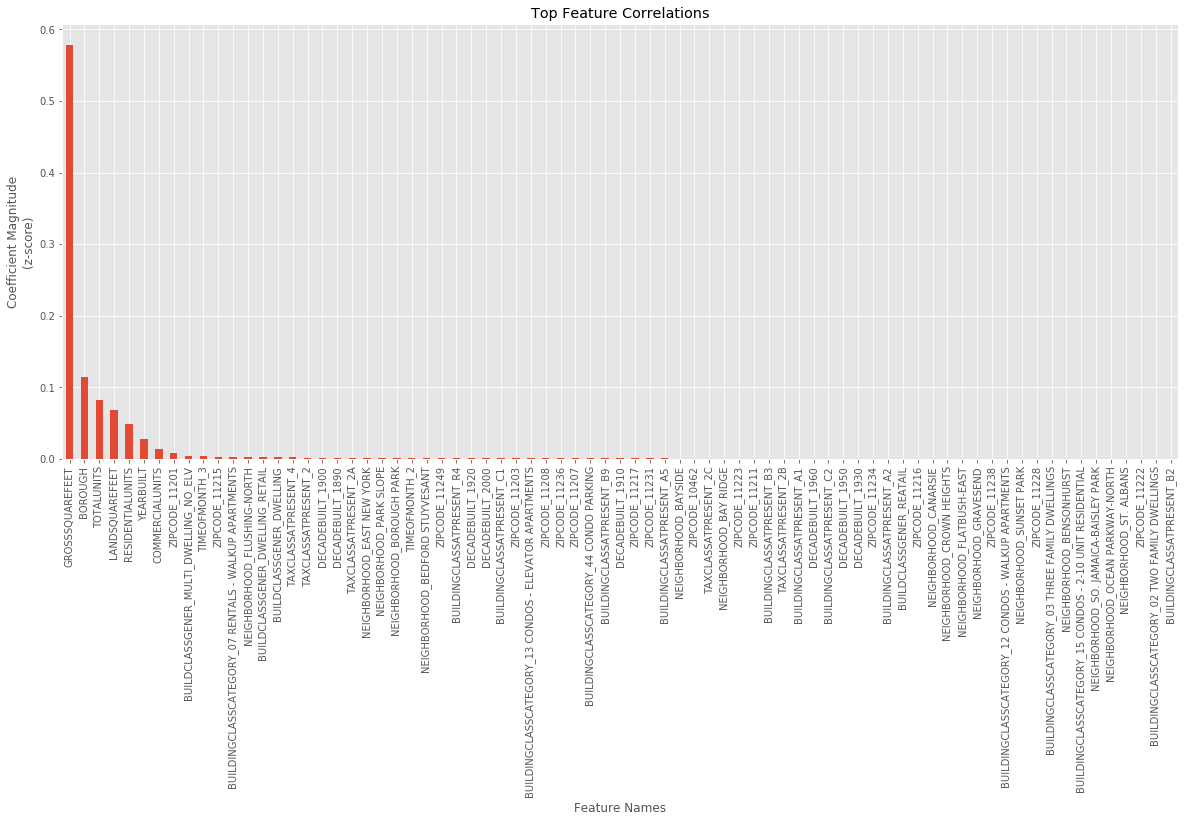

In [86]:
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()